# Summary of Saitta et. al. (2020) - "An Effect Size Statistical Framework for Investigating Sexual Dimorphism in Non-avian Dinosaurs and Other Extinct Taxa"

This paper is largely looking at a novel way of looking at and detecting sexual dimorphism, and specifically sexual size dimorphsim (SSD), in extinct taxa. They note that despite the fact that SSD is widespread today, there is little evidence that it existed in dinosaurs. This seems strange; it could be that dinosaurs were unique in that there was some process that selected against sexual dimorphism, or it could be that the techniques that we're using are not fit for purpose. The authors propose using a method which looks at the asymptotic size of different sexes and using that as a measure of sexual dimorphism. This neatly sidesteps one of the issues with discovering it so far, first raise (as far as I know) in Hone and Mallon (2017) - the fact that having fossils with different ages makes testing for sexual size dimorphism very difficult and prone to false negatives. By using the growth curve of the taxa, they actually rely on having this information.

The first thing they do is go through an examination of the significance of sexual dimorphism, including a summary of previous work on extinct taxa and its role in modern ecology. They also go through various explanations for why it has been difficult to find definitive examples of sexual dimorphism in the fossil record: namely the Species Recognition Hypothesis and the Mutual Sexual Selection Hypothesis. They conclude that these are unlikely to be the true cause, and it is more likely that the fault lies with the statistical methods employed thus far.

The next step is to examine these existing methods!

## Previous Methods

### Bimodality method

The first commonly used method is to use the Hartigan Dip Test for Unimodality (Hartigan, 1985). This test is calculated based on an assumption of unimodality, and so any low $p$ value can be interpreted as evidence against this hypothesis and therefore as evidence for bimodality (or three modes, or essentially any number of modes greater than 1). An excellent visual explanation of the test is presented [here](https://skeptric.com/dip-statistic/index.html). This is relevant in the context of looking for evidence of sexual dimorphism because the assumption is that if you are looking at some sort of trait and see two peaks, it could be that those are the result of the final distribution being a combination of two dimorphic distributions, and would thus be evidence for sexual dimorphism (with the usual caveats that dimorphism need not necessarily be sexual in nature).

Before we move on to the downsides the authors point out with this method, let's take a look at some example distributions and the results of the Hartigan Dip Test to get a feel for what this test is telling us. For simplicity I'll stick with bimodal distributions.

In [6]:
# first load all necesary library, utility functions, &c.
library(diptest)
library(ggplot2)

custom_theme <- function() {
  theme_minimal() +
    theme(
      panel.background = element_rect(fill = "white"),
      panel.grid.major = element_line(color = alpha("black", 0.5), linetype = "dotted", linewidth = 0.5),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 12),  # Adjust the font size of axis labels
      axis.title = element_text(size = 16),  # Adjust the font size of axis titles
      plot.title = element_text(size = 20, hjust = 0.5),  # Adjust the font size and center the plot title
      plot.subtitle = element_text(size = 16, hjust = 0.5)  # Adjust the font size and center the plot subtitle
    )
}
options(repr.plot.width=15, repr.plot.height=8)

Before we dive too deeply into that, let's look at one example in detail. First, we'll generate two samples: one from a normal distribution (unimodal) and one combined sample from two different normal distributions with different means (a bimodal sample).

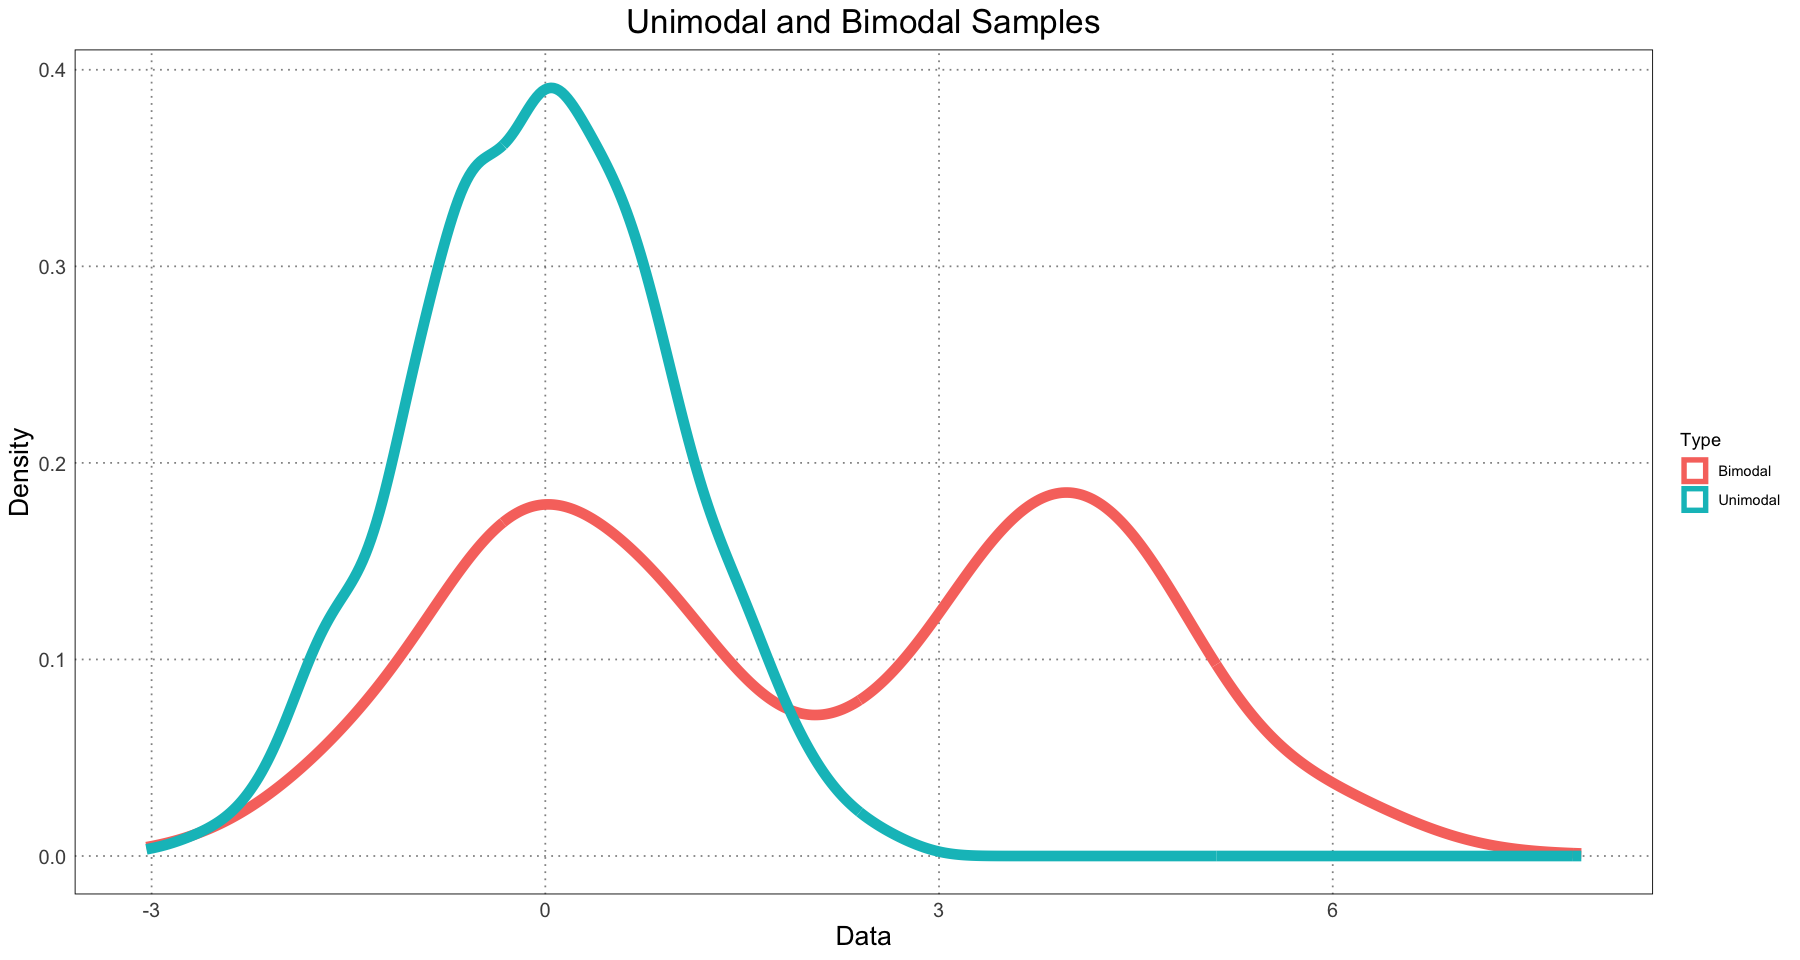

In [144]:
unimodal_sample <- rnorm(1e3, mean = 0, sd = 1)
bimodal_sample <- c(
    rnorm(5*1e2, mean = 0, sd = 1),
    rnorm(5*1e2, mean = 4, sd = 1)
)

sample_df <- data.frame(data = c(unimodal_sample, bimodal_sample), type = rep(c("Unimodal", "Bimodal"), each = 1e3))

ggplot(sample_df, aes(data, group = type, colour = type)) +
    geom_density(linewidth=3) +
    custom_theme() +
    labs(title = "Unimodal and Bimodal Samples", x = "Data", y = "Density", colour = "Type")

Now let's look at the unimodal sample. We'll use Hartigans' Dip Test and compute a $p$ value against the null hypothesis of unimodality. Since the distribution is in fact unimodal, we expect a very high value (hopefully close to 1).

In [127]:
# test the sample, using B = 1e4 Monte Carlo replicates. See the documentation for more details
hdt <- dip.test(unimodal_sample, simulate.p.value = TRUE, B = 1e4)
hdt


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 10000 replicates)

data:  unimodal_sample
D = 0.0076326, p-value = 0.9881
alternative hypothesis: non-unimodal, i.e., at least bimodal


As per the documentation, `hdt` is a list containing a few different attributes related to the test. For us, the most relevant one is `p.value`.

In [128]:
hdt$p.value

[1] 0.9881

As expected, it is close to 1. Now let's try the same thing for the bimodal distribution!

In [129]:
(hdt_bimodal <- dip.test(bimodal_sample, simulate.p.value = TRUE, B = 1e4))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 10000 replicates)

data:  bimodal_sample
D = 0.038303, p-value < 2.2e-16
alternative hypothesis: non-unimodal, i.e., at least bimodal


In [130]:
hdt_bimodal$p.value

[1] 0

Here, as we expect, the $p$ value is essentially zero, allowing us to reject the null hypothesis of unimodality.

Note that in all of the above we are using a Monte Carlo simulation to generate the $p$ value. This process can be somewhat time-intensive (it take my computer roughly 2 -- 3 seconds to compute it with 10 000 replicates). There is another way to compute the $p$ value by using a lookup table, and in fact this is the default behaviour (controlled by the `simulate.p.value` parameter). However, to keep with the method employed in the paper I will use the Monte Carlo method. I am unclear as to the advantages of this method, and to be honest the entire test is slightly opaque to me. Definitely an area for further study!

Great! Now that we have looked at a few examples, let's look at a wider range of bimodalities to get a sense for the results of the test.

In [131]:
# generates a bimodal sample by combining two normal distributions with the same standard deviation
generate_bimodal <- function(mu1, mu2, sd, num_samples = 1e4) {
    c(
        rnorm(num_samples / 2, mean = mu1, sd = sd),
        rnorm(num_samples / 2, mean = mu2, sd = sd)
    )
}

df <- data.frame(data = numeric(), p = numeric(), mu2 = numeric())
for (mu2 in seq(0, 4, by = 0.5)) {
    data <- generate_bimodal(mu1 = 0, mu2 = mu2, sd = 1)
    simulated_p_value <- dip.test(data, simulate.p.value = TRUE, B = 1e4)$p.value
    interim_df <- data.frame(data = data, p = simulated_p_value, mu2 = mu2)
    df <- rbind(df, interim_df)
}

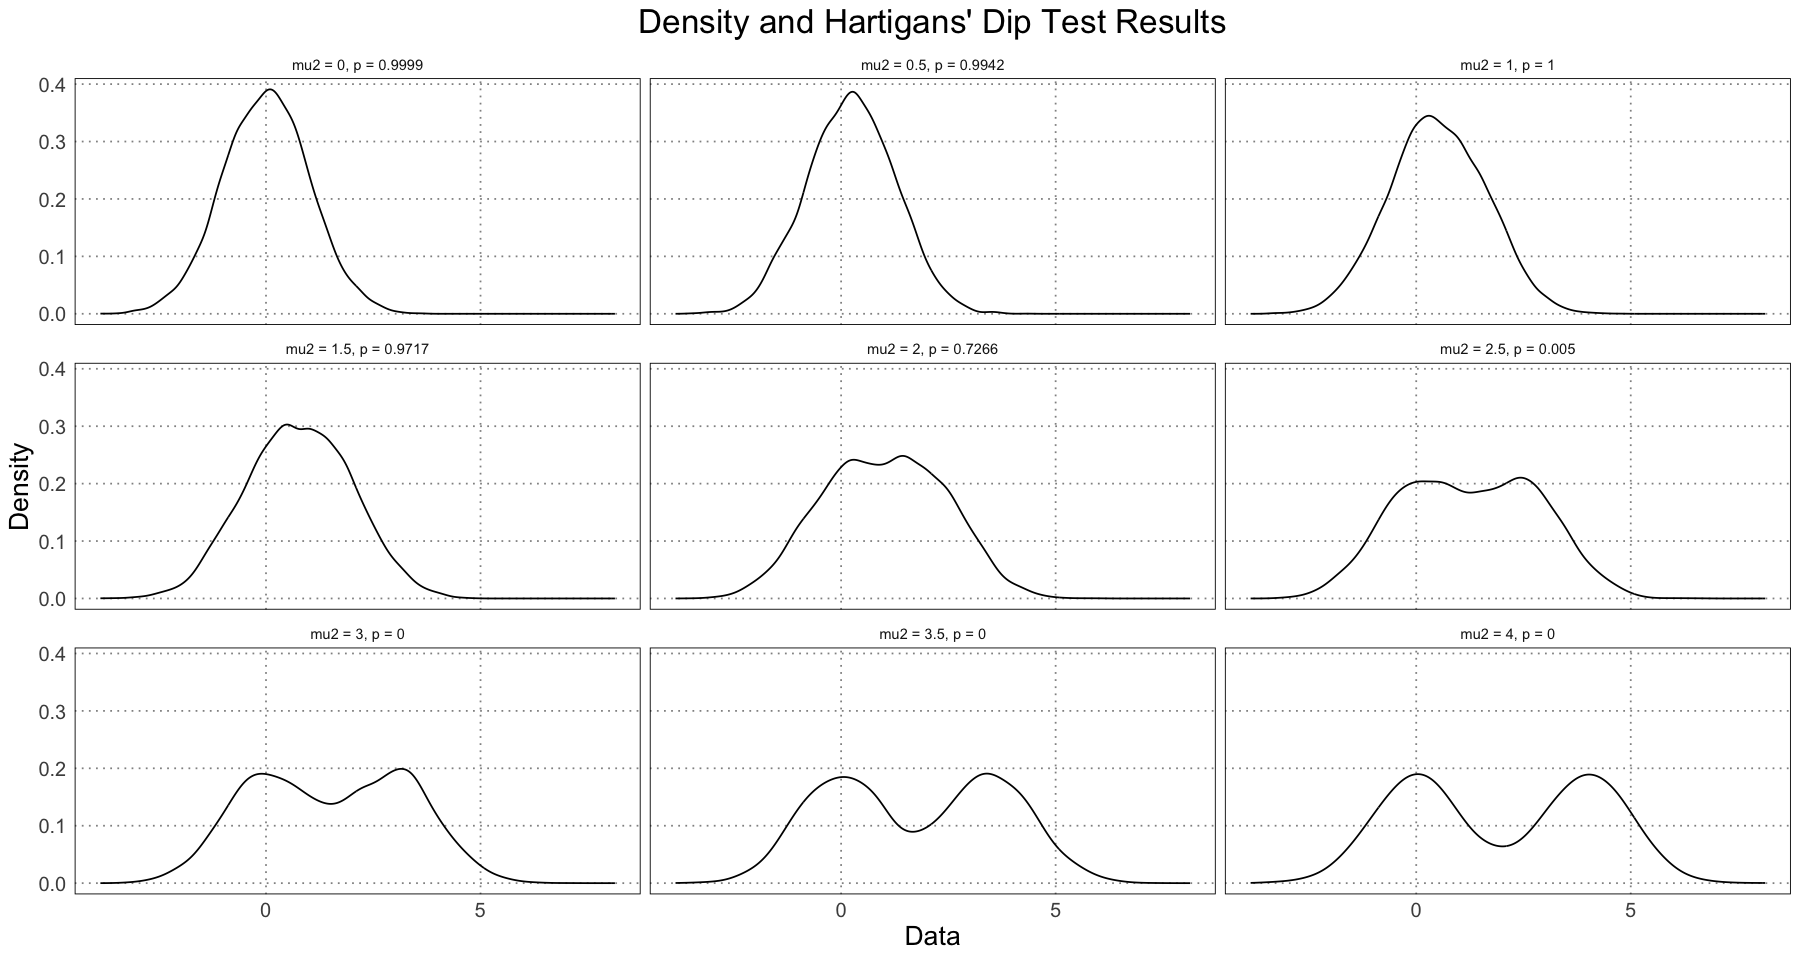

In [132]:
df$label <- paste("mu2 = ", df$mu2, ", ", "p = ", trunc(df$p * 1e5) / 1e5, sep = '')
ggplot(df, aes(data)) +
    geom_density() +
    facet_wrap(vars(label)) +
    labs(title = 'Density and Hartigans\' Dip Test Results', x = 'Data', y = "Density") +
    custom_theme()

Note that just by examining the density plots, we can see that we don't see bimodality occurring until the difference in the means was greater than $2\sigma$. This is not just a result of our data, but something that will always be true; if the distributions have means that are too close, the resulting distribution will be unimodal. In addition, note that the $p$ value changes very rapidly between $\mu_2 = 2$ (unimodal) and $\mu_2 = 3$ (bimodal). In fact, let's zoom in on this area to see this change in more detail.

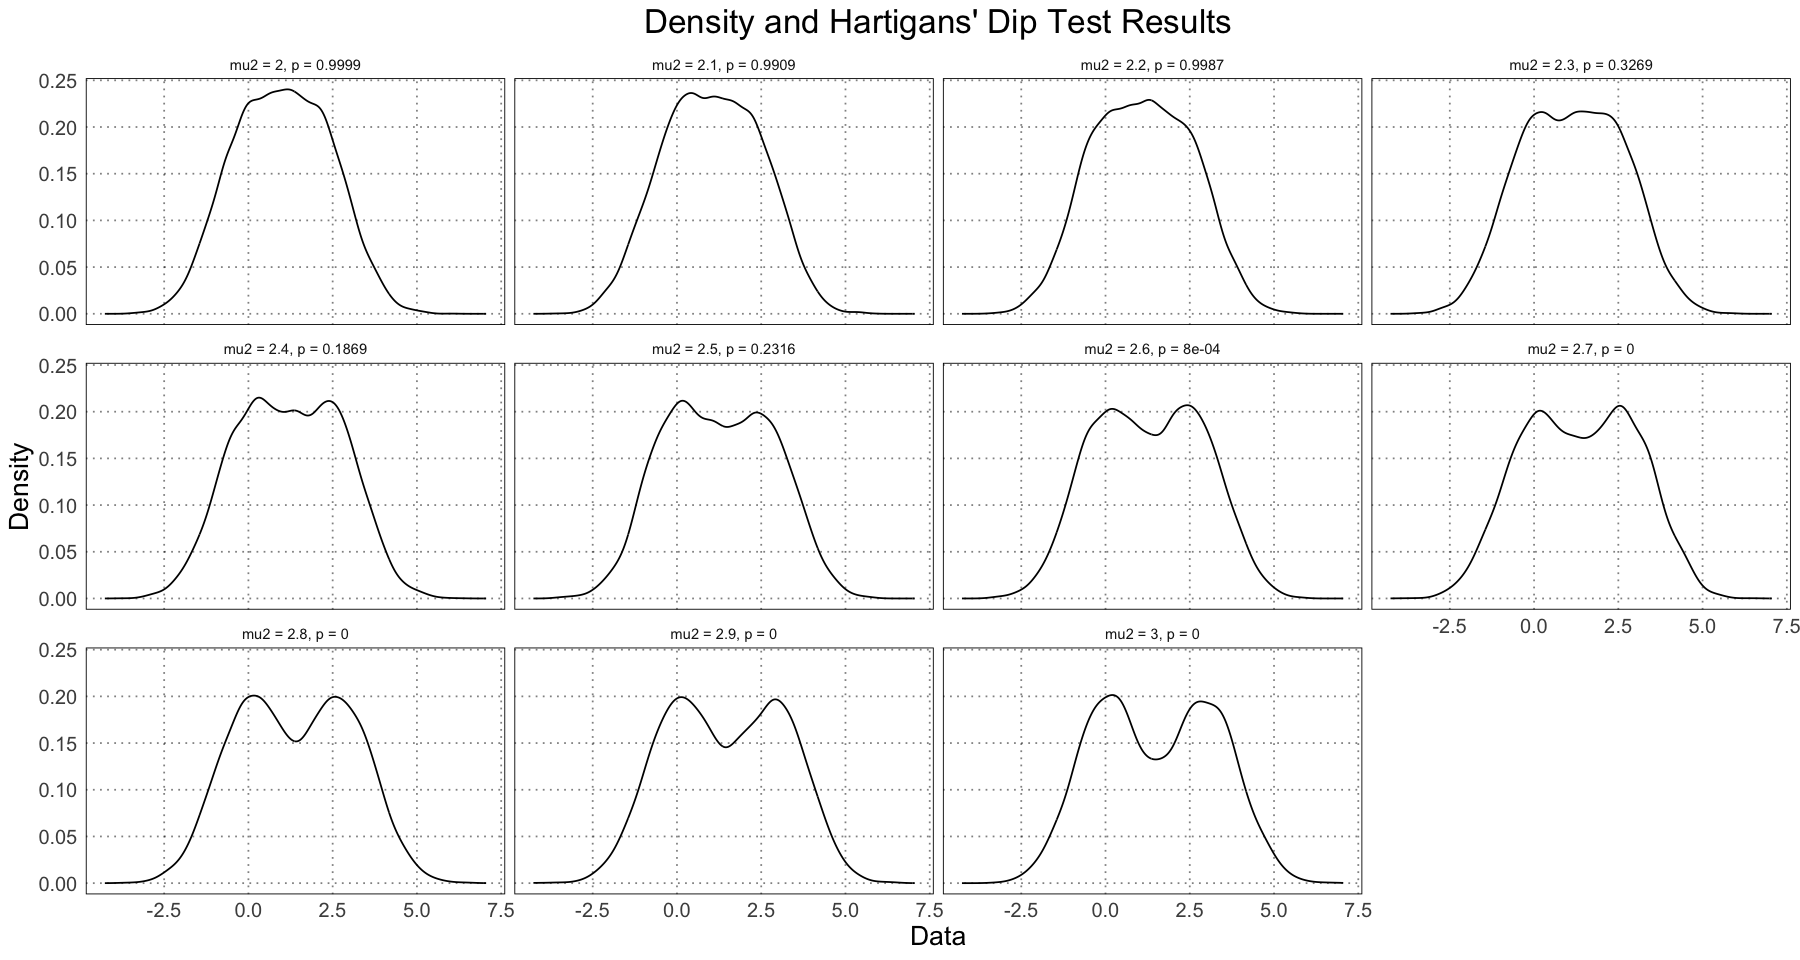

In [133]:
df <- data.frame(data = numeric(), p = numeric(), mu2 = numeric())
for (mu2 in seq(2, 3, by = 0.1)) {
    data <- generate_bimodal(mu1 = 0, mu2 = mu2, sd = 1)
    simulated_p_value <- dip.test(data, simulate.p.value = TRUE, B = 1e4)$p.value
    interim_df <- data.frame(data = data, p = simulated_p_value, mu2 = mu2)
    df <- rbind(df, interim_df)
}
df$label <- paste("mu2 = ", df$mu2, ", ", "p = ", trunc(df$p * 1e5) / 1e5, sep = '')
ggplot(df, aes(data)) +
    geom_density() +
    facet_wrap(vars(label)) +
    labs(title = 'Density and Hartigans\' Dip Test Results', x = 'Data', y = "Density") +
    custom_theme()

As another example from the paper, they look at how large the height dimorphism would have to be between male and female humans in order to be detectable using this test. The method was to fix the female height as $h_f \sim \text{Normal}(162, 7)$ and allowing the male height to vary from 176 cm - 200 cm while keeping the standard deviation fixed. They then generated 1000 datasets of different sizes (20 - 20 000 under a log scale) and took the average value of the Hartigans' dip test for each of these, plotting the results.

If you are following along at home, not that this takes *forever* to run. If you just want to get quick results (which are basically the same), reduce the number of sample sizes and don't use the Monte Carlo method for generating the $p$ value (see commented out code below). I am doing it this way to follow the method outlined in the paper. In fact, I've even reduced the number of Monte Carlo replicates for the $p$ value to avoid having it take literally days to run. To give some quick benchmarks, the code below (100 replicates) took about two hours to run on a 2020 MackBook Air (M1); a quick estimate put running it with the 10 000 replicates they used in the paper at about a week (!).

In [139]:
NUM_MONTE_CARLO_REPLICATES = 1e2
FEMALE_HEIGHT <- 162
male_heights <- seq(176, 200, by = 2)
# going from 20 - 20 000 in 7 steps (by log)
total_sample_sizes <- round(exp(seq(log(20), log(2 * 1e4), length.out = 7)))
NUM_SAMPLES <- 1e3
# NUM_SAMPLES <- 1e1 # to speed up the process

generate_mean_hdt_p <- function(sample_size, male_height, num_monte_carlo_replicates = 1e4) {
    ps <- rep(NA, NUM_SAMPLES)
    for (i in 1:NUM_SAMPLES) {
        data <- generate_bimodal(mu1 = FEMALE_HEIGHT, mu2 = male_height, sd = 7, num_samples = sample_size)
        ps[i] <- dip.test(data, simulate.p.value = TRUE, B = num_monte_carlo_replicates)$p.value
        # ps[i] <- dip.test(data)$p.value # to speed it up
    }
    mean(ps)
}

steps <- length(male_heights) * length(total_sample_sizes)
step <- 1
progress_bar <- txtProgressBar(min = 1, max = steps, initial = 1, style = 3)
df <- data.frame(male_height = numeric(), sample_size = numeric(), p = numeric())
for (male_height in male_heights) {
    for (sample_size in total_sample_sizes) {
        mean_p <- generate_mean_hdt_p(sample_size, male_height, num_monte_carlo_replicates = NUM_MONTE_CARLO_REPLICATES)
        df <- rbind(df, data.frame(
            male_height = male_height, sample_size = sample_size, p = mean_p
        ))
        step <- step + 1
        setTxtProgressBar(progress_bar, step)
    }
}
close(progress_bar)

head(df)
summary(df)

  |                                                                      |   0%

  |======================================================================| 100%


male_height sample_size p      
1 176           20        0.60362
2 176           63        0.68208
3 176          200        0.76633
4 176          632        0.84480
5 176         2000        0.89328
6 176         6325        0.92345

  male_height   sample_size          p          
 Min.   :176   Min.   :   20   Min.   :0.00000  
 1st Qu.:182   1st Qu.:   63   1st Qu.:0.00000  
 Median :188   Median :  632   Median :0.00285  
 Mean   :188   Mean   : 4177   Mean   :0.19084  
 3rd Qu.:194   3rd Qu.: 6325   3rd Qu.:0.35314  
 Max.   :200   Max.   :20000   Max.   :0.95436  

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


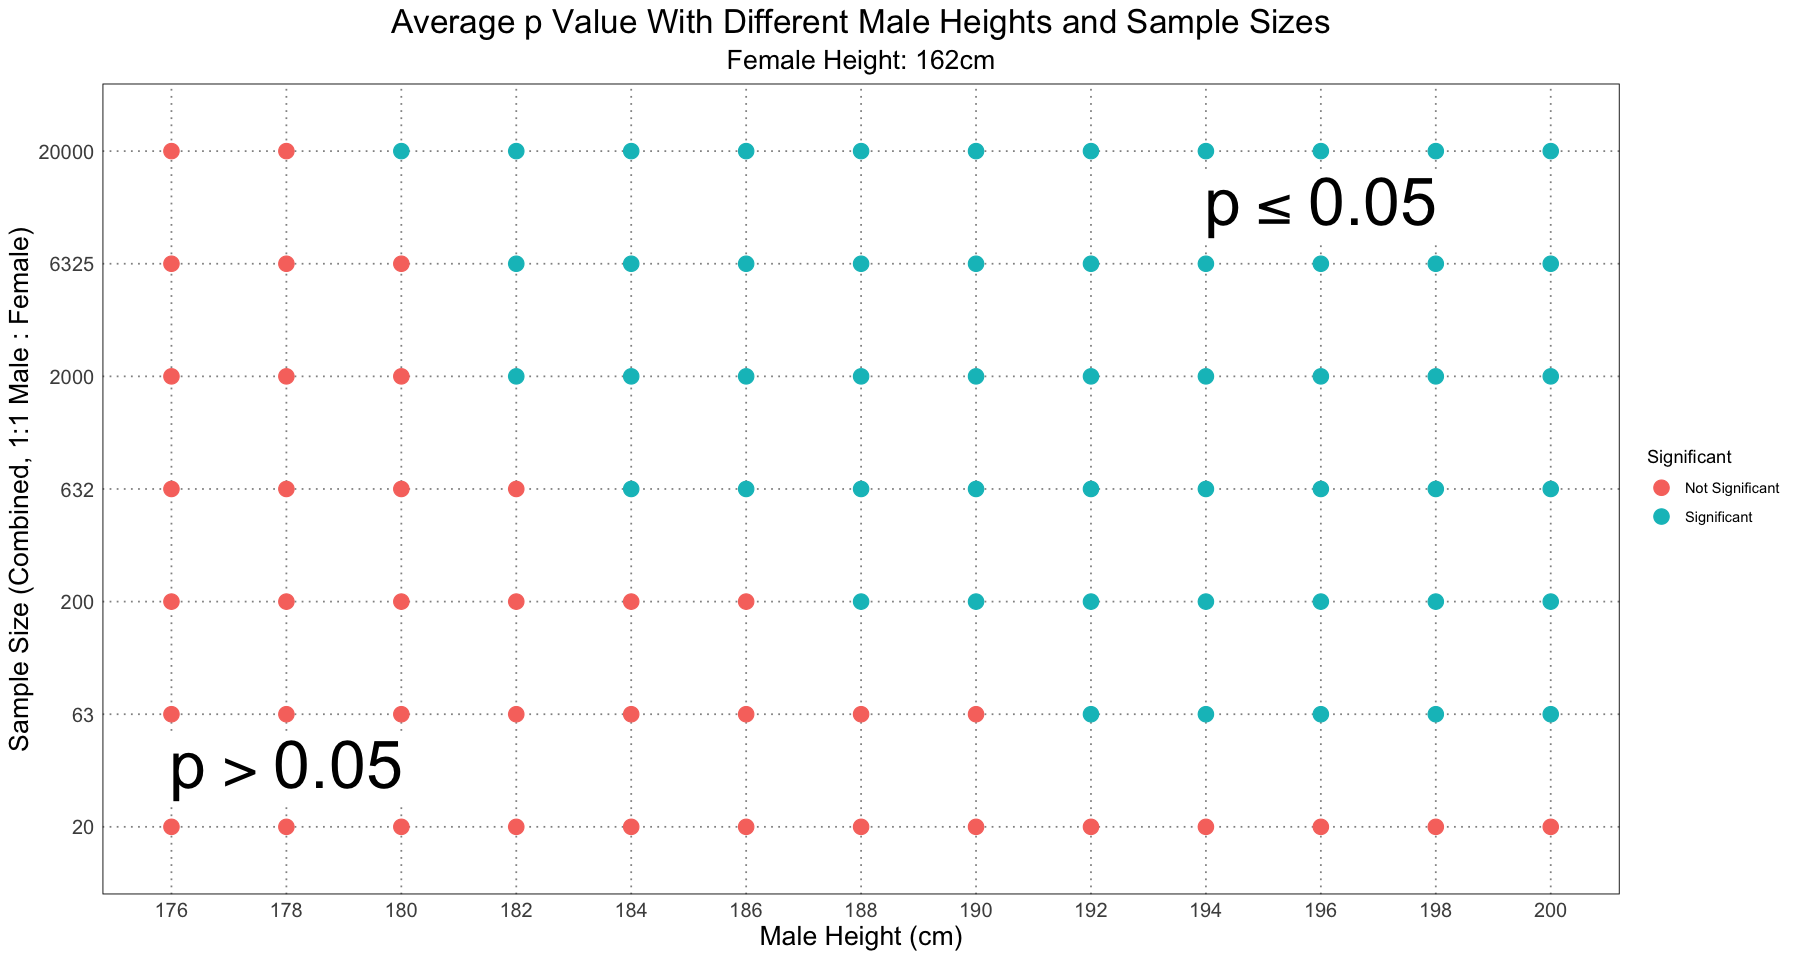

In [142]:
alpha <- 0.05
df$significant <- df$p < alpha
df$sample_size <- factor(df$sample_size)
ggplot(df, aes(male_height, sample_size, colour = significant)) +
    geom_point(size = 4) +
    labs(title = "Average p Value With Different Male Heights and Sample Sizes", x = "Male Height (cm)", y = "Sample Size (Combined, 1:1 Male : Female)", subtitle=paste("Female Height: ", FEMALE_HEIGHT, 'cm', sep = ""), colour = "Significant") +
    annotate('label', label = expression(p <= 0.05), x = 196, y = 6.5, size = unit(14, 'pt'), fill = 'white', label.size = NA) +
    annotate('label', label = expression(p > 0.05), x = 178, y = 1.5, size = unit(14, 'pt'), fill = 'white', label.size = NA) +
    scale_color_discrete(labels = c("Not Significant", "Significant")) +
    scale_x_continuous(breaks = male_heights, labels = male_heights) +
    custom_theme()


This graph is almost identical to Figure 2 in the paper, and from looking at the supplementary information I can confirm that the method was the same. The few discrepancies (notably: I have the samples of size 20 and male height 200cm as not significant, but in Figure 2 it is marked as significant) I am fairly confident I can put down to the fact that I am using fewer Monte Carlo replicates than they did when computing the $p$ value for the dip test. As I was experimenting with different values, I did notice that the values on the fringe of significant / not significant were quite sensitive to choices of the number of replicates, the number of samples, and whether or not to use the Monte Carlo method to compute the $p$ value or use the lookup table. 

Nonetheless, the basic idea remains: even with human height, widely acknowledged as an example of sexual size dimorphism, Hartigans' dip test did not recover it as being dimorphic (see the column where male height was 176cm). For even quite extreme levels of dimorphism, you need an unrealistically large (in terms of fossil specimens) sample size to recover the dimorphism.


Just for interest's sake, let's look at a contour plot of the $p$ values to get a better feel for what's happening there (rather than just significant / not significant).

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


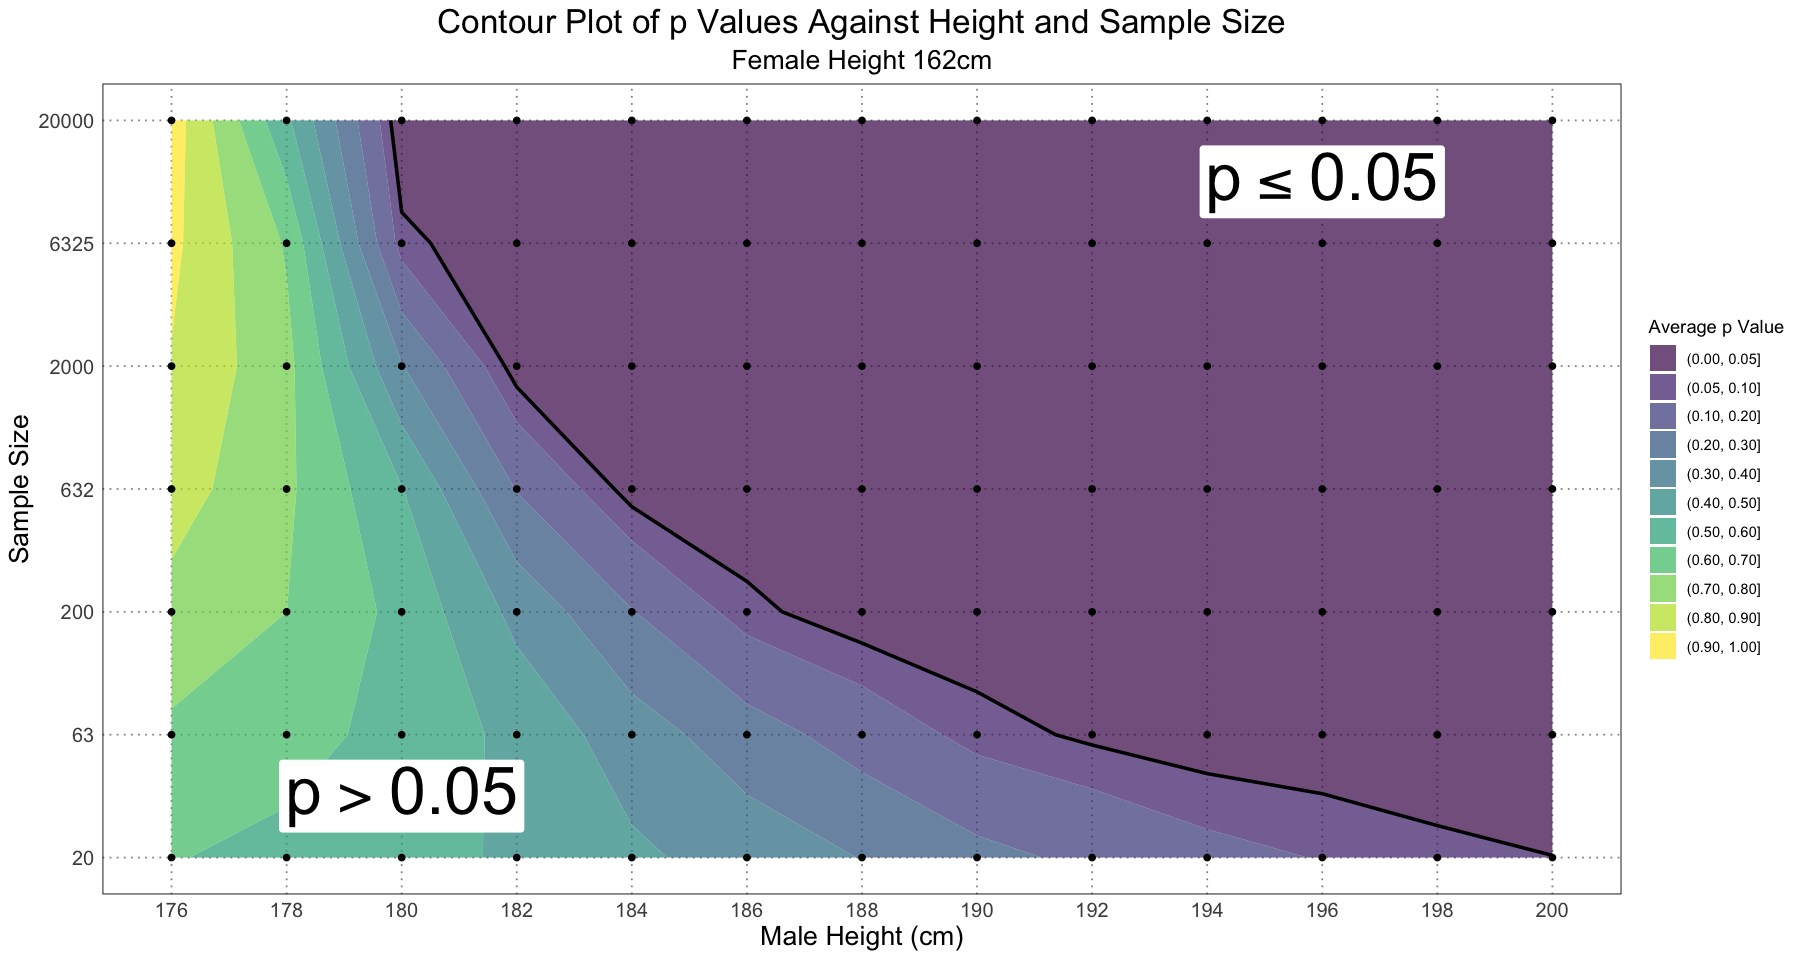

In [203]:
contour_df <- data.frame(male_height = df$male_height, sample_size = as.numeric(df$sample_size), p = df$p, significant = df$significant)
contour_breaks <- c(0, alpha, seq(0.1, 1, by = 0.1))
ggplot(contour_df, aes(male_height, sample_size, z = p)) +
    geom_contour_filled(breaks = contour_breaks, alpha = 0.7) +
    geom_contour(aes(linewidth = after_stat(level == alpha)), breaks = contour_breaks, colour = 'black', show.legend = FALSE) +
    scale_linewidth_manual(values = c(0, 1)) +
    geom_point() +
    labs(title = "Contour Plot of p Values Against Height and Sample Size", subtitle = 'Female Height 162cm', x = "Male Height (cm)", y = "Sample Size", fill = "Average p Value") +
    annotate('label', label = expression(p <= 0.05), x = 196, y = 6.5, size = unit(14, 'pt'), fill = 'white', label.size = NA) +
    annotate('label', label = expression(p > 0.05), x = 180, y = 1.5, size = unit(14, 'pt'), fill = 'white', label.size = NA) +
    scale_y_continuous(labels = levels(df$sample_size), breaks = unique(contour_df$sample_size)) +
    scale_x_continuous(breaks = unique(contour_df$male_height), labels = unique(contour_df$male_height)) +
    custom_theme()

Alternatively, we could focus in on the area where $p \leq 0.05$ (the significant region) to see how those values change:

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


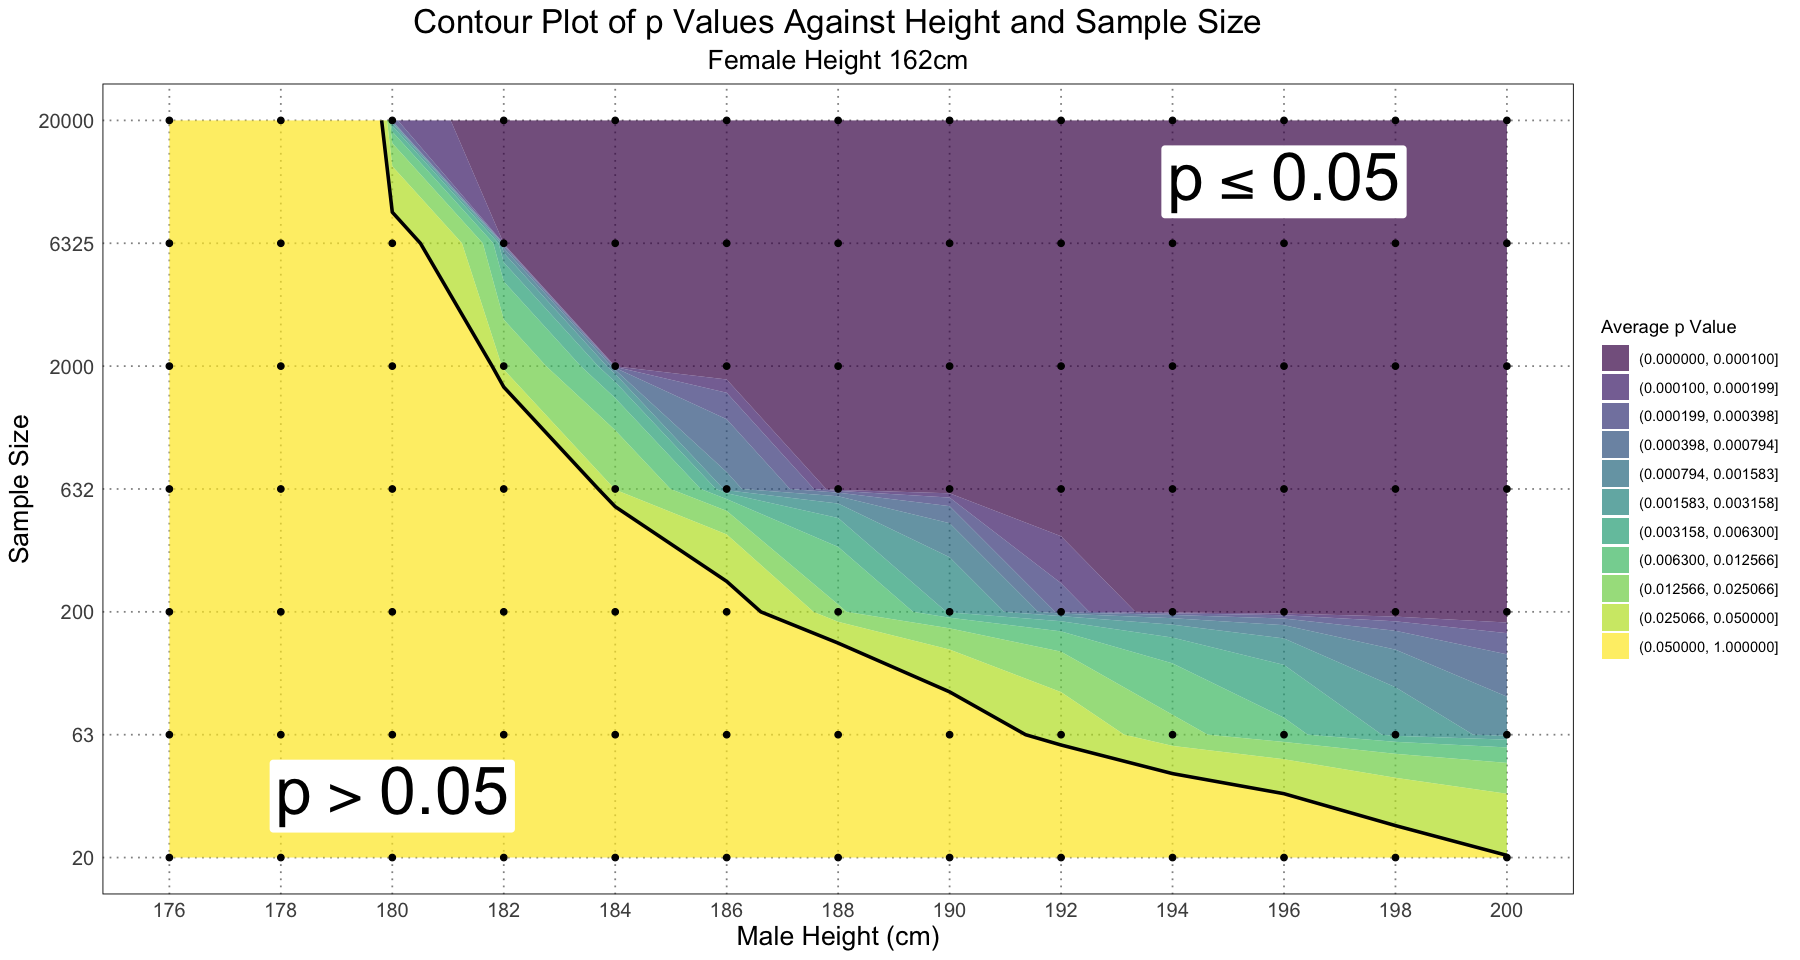

In [205]:

# from close to zero to alpha = 0.05 in 10 equally spaced log steps
p_value_seq <- exp(seq(log(1e-4), log(alpha), length.out = 10))
contour_breaks <- c(0, p_value_seq, 1)
ggplot(contour_df, aes(male_height, sample_size, z = p)) +
    geom_contour_filled(breaks = contour_breaks, alpha = 0.7) +
    geom_contour(aes(linewidth = after_stat(level == alpha)), breaks = contour_breaks, colour = 'black', show.legend = FALSE) +
    scale_linewidth_manual(values = c(0, 1)) +
    geom_point() +
    labs(title = "Contour Plot of p Values Against Height and Sample Size", subtitle = 'Female Height 162cm', x = "Male Height (cm)", y = "Sample Size", fill = "Average p Value") +
    annotate('label', label = expression(p <= 0.05), x = 196, y = 6.5, size = unit(14, 'pt'), fill = 'white', label.size = NA) +
    annotate('label', label = expression(p > 0.05), x = 180, y = 1.5, size = unit(14, 'pt'), fill = 'white', label.size = NA) +
    scale_y_continuous(labels = levels(df$sample_size), breaks = unique(contour_df$sample_size)) +
    scale_x_continuous(breaks = unique(contour_df$male_height), labels = unique(contour_df$male_height)) +
    custom_theme()


The next thing the authors looked at was the effect of changing the ratio of males / females in the sample or changing the standard deviations of the populations. Unsurprisingly, in both cases this had the effect of making dimorphism difficult to detect. In addition, they referenced Mallon (2017)'s use of mixture modelling to test the hypothesis of dimorphism. The basic idea is that he looked at different mixture models and used the Akaike Information Criterion to select the best model; if that was a mixture of two it was taken as evidence for sexual dimorphism. I am going to largely ignore this approach for the pragmatic reason that I believe it is a fruitful area for further research but my understanding of the underlying ideas is not yet good enough to approach it properly.

The next section was largely an overview of the methods and results of Hone & Mallon (2017), where they looked at the difficulty of using $t$ tests to find evidence of dimorphism even in the case where the sex of the subjects is known (using simulated populations of American alligators and rheas). They also looked at the effect of population structure (preponderence of juveniles) and taphonomic bias (lower preservation rate for smaller individuals) and looked at the effect that that had on the ability to detect dimorphism. Essentially, they found that you would need unrealistic sample sizes to have any hope of detecting even lage degrees of dimorphism, even in the even more unrealistic scenario where you knew the sex of each sample. As I have explored this paper in a fair degree of detail elsewhere, I'll leave it at that.

## A New Approach

The main part of the paper is the proposal for a new method of finding and quantifying dimorphism. The main innovation in this method is that they lean in to the problems caused by having individuals of different ages in the sample by using them to construct a growth curve of the taxon in question. This then turns a *disadvantage* into an *advantage*. In the previous methods, having individuals of different ages can lead to greater overlap in the sizes of dimorphic individuals (e.g. a young male might look in size like an order female), whereas with this method having individuals of different sizes can lead to better resolution for the growth curve and thus greater confidence in the computed values. Once you have a growth curve, then if you are looking for evidence of sexual dimorphism the next step is to rule out other sources of variation.

The first thing to check against is non-sexual variation and polymorphism. Once thing to check against is the presence of more than two 'morphs'. For instance, if you see three or more natural groups within the data, it would seem unlikely that sexual variation is the culprit. Another thing to check against is that you are not seeing the result of population-level differences (for instance, if you have two different populations of the same species but which happen to be different sizes, that might look like sexual dimorphism). In order to counter this, you should aim to get the data from a single location and time; the wider the discrepancy in either of these, the less certain you can be that you are not just looking at population-level differences.

Once you have the data, you can examine it for evidence of dimorphism. This could come in the form of a clear separation of points along the regression curve or as a widening of the data. In simulations, alligators (continuous growth) show a clear separation while rheas (deterministic growth) show a widening with no clear separation.

The next step is to assign the sex of each individual. In the absence of other indicators (e.g. medullary bone or other such unambigious indicators), a simple way of doing this is to fit a growth curve to the data as a whole and then assign individuals above the curve to one sex and those below it to another. While this method is easy to understand and computationally easy, it has the major disadvantage of biasing the results in favour of finding sexual dimorphism; that is, a population with a small degree of dimorphism (or even no dimorphism) will show some level of difference using this method. Nonetheless, in realistic situations the accuracy can be surprisingly high.

This seems like the weakest part of the paper to me (which is fair; determining the sex of fossil specimens is a hard problem!). They certainly include different ideas for further research (mixture modelling, k-means clustering, &c.) and it would be very interesting to look more into these approaches. For now we'll just take it as a given that we can use this method and see what the results look like.

Once the sex has been assigned, the next step is to separately fit a growth curve to each of the sexes. This then allows you to estimate the level of dimorphism; in the paper they used the difference in the asymptotic length or mass of each sex. From there, you can compute confidence or prediction intervals, &c. In the paper, they also examined the difference in the maximum of the smaller sex and the minimum of the larger one and also the difference in the maximum of the larger and the minimum of the smaller to see how much spread / variation there is in the characteristic.

To summarize, the steps are:
1. Get data, including age (or a proxy for age) and the feature suspected to be dimorphic
1. Fit a growth curve to the data
1. Assign a sex to each individual; as one method, assign all individuals above the combined growth curve to one sex and those below to the other
1. Fit separate growth curves to each sex
1. Estimate the extent of dimorphism as the difference in the asymptotic sizes of each sex
1. Use the confidence / prediction intervals to determine measures of separation and spread

## Step-By-Step

Let's take a look at what this process looks like by going through this process using simulated American alligator data from Hone & Mallon (2017) (originally from Wilkinson & Rhodes (1997)). Note that this was not explicitly part of the paper, although thanks to the fact that they included their code in the Supplemental Information (*with* comments, for which they should receive some sort of award or recognition) it is easy enough to find.

Recall that the alligator growth data was modelled by a von Bertalanffy curve with different means and standard deviations for each sex. For the purposes of this simulation, we will be considering age (in years) against body length and looking for a sexually dimorphic signal. Of course, since this is a simulation and we know the curve from which the body lengths are generated, we already know the answer.

$$
\begin{align*}
L_m &= 3.79 * (1 - 0.94 e^{-0.0695t}) \\
\sigma_{L_m} &= 0.0589 \log L_m + 0.0816 \\
L_f &= 2.78 * (1 - 0.91 e^{-0.0926t}) \\
\sigma_{L_f} &= 0.0332 \log L_f + 0.046 \\
\end{align*}
$$

Note that the form used here is slightly different from the general form of the von Bertalanffy curve; a simple transformation of the exponential gives us the empirical one

$$
\begin{align*}
C &= L_\infty \left(1 - e^{-K(P-t)}\right) \\
    &= L_\infty \left(1 - e^{Kt} \ast e^{-KP}\right) \\
    &= L_\infty \left(1 - A e^{-KP}\right) \\
\end{align*}
$$

Nothing tricky, but probably best to be explicit. Also note that the $t$ variables in the empirical function corresponds to $P$ in the general one.

Since we're looking for the magnitude of dimorphism, let's also be explicit about that. Since both the male and female alligator lengths are described by curves of the same shape, we have

$$
\begin{align*}
L_M &= L_{M,\infty}\left( 1 - A_M e^{-K_M t}\right) \\
L_F &= L_{F,\infty}\left( 1 - A_F e^{-K_F t}\right) \\
\end{align*}
$$

In general, when we discuss the amount of dimorphism we are looking for the difference in asymptotic length; in this case, $L_{M,\infty} - L_{F,\infty}$ = 3.79 - 2.78 = 1.01. This has an easy interpretation: if we look at very old individuals, we expect the males to be about 1m longer than the females. This is the absolute difference; later when we compare different species we will need some sort of comparison that is not dependent on the actual measurement, but we'll get to that later.

Since we'll be using these a lot, let's write some functions to generate the data.

In [10]:
generate_male_alligator_mean_lengths <- function(t) {
    3.79 * (1 - 0.94 * exp(-0.0695 * t))
}

generate_male_alligator_sigma <- function(lengths) {
    0.0589 * log(lengths) + 0.0816
}

generate_female_alligator_mean_lengths <- function(t) {
    2.78 * (1 - 0.91 * exp(-0.0926 * t))
}

generate_female_alligator_sigma <- function(lengths) {
    0.0332 * log(lengths) + 0.046
}

generate_alligator_samples <- function(t, sex) {
    if (sex == "M") {
        length_function <- generate_male_alligator_mean_lengths
        sigma_function <- generate_male_alligator_sigma
    } else if (sex == "F") {
        length_function <- generate_female_alligator_mean_lengths
        sigma_function <- generate_female_alligator_sigma
    }
    lengths <- length_function(t)
    sigmas <- sigma_function(lengths)
    rnorm(length(t), mean = lengths, sd = sigmas)
}

Now that we have the curves, let's generate some samples and see what the distribution looks like.

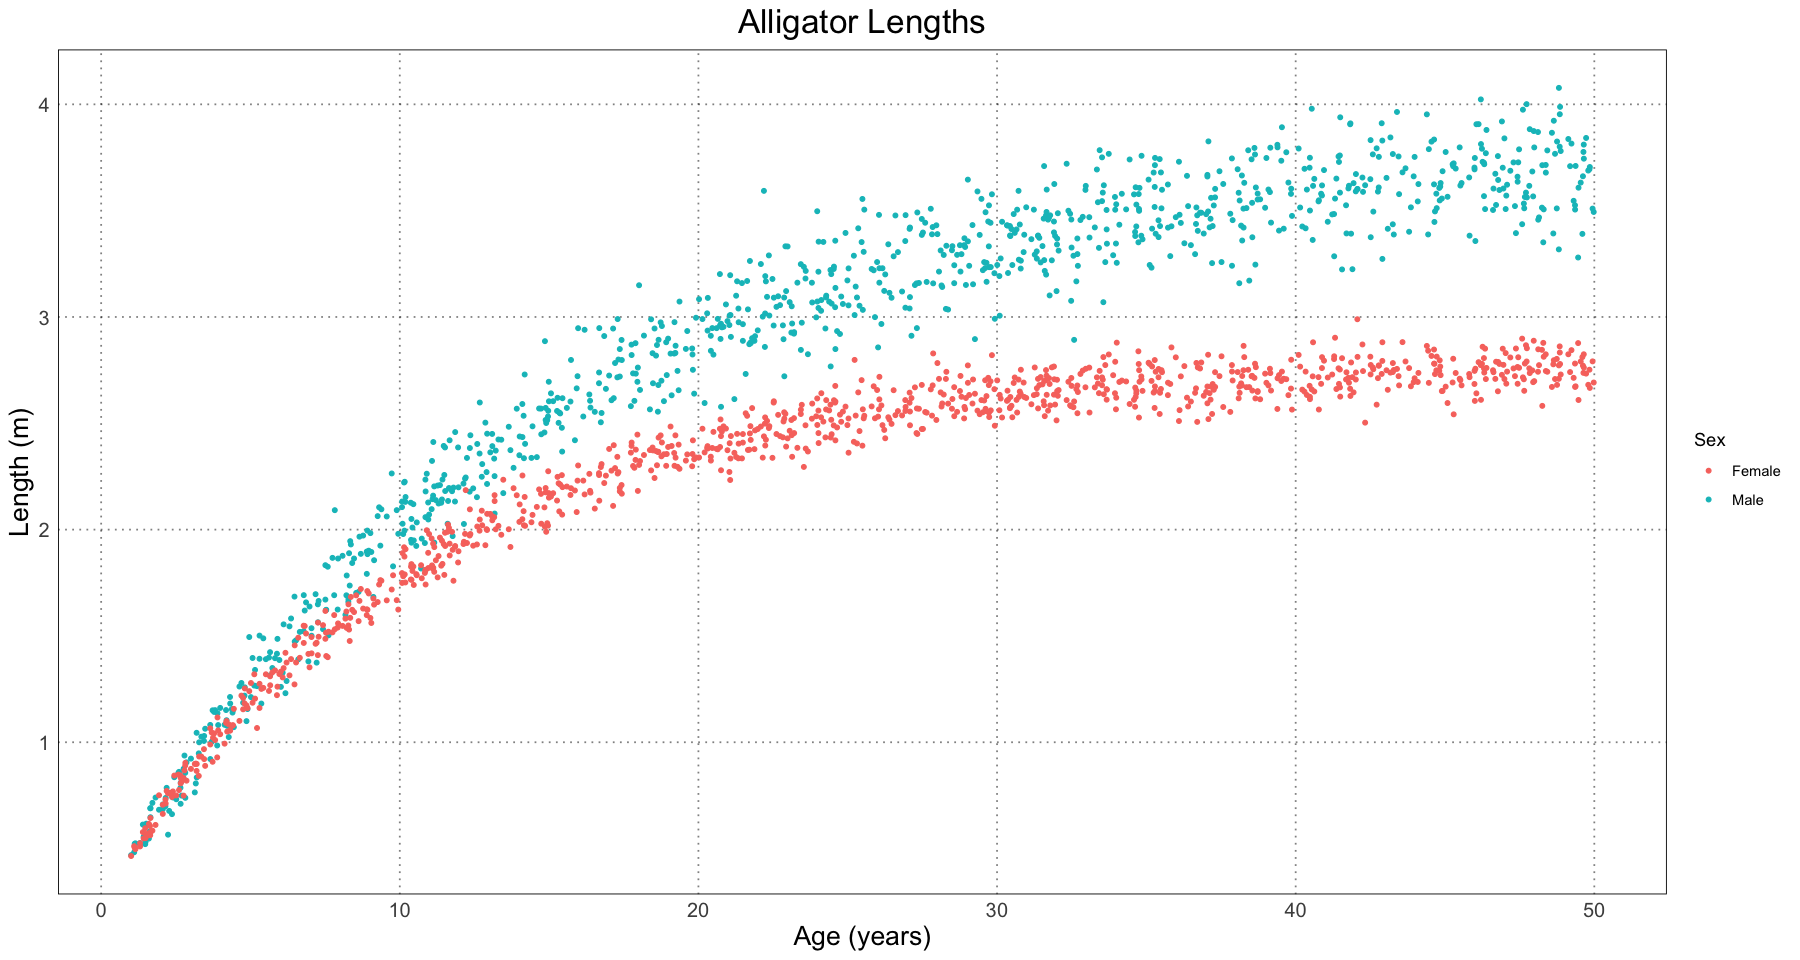

In [24]:
ALLIGATOR_MAX_LIFESPAN <- 50
t <- runif(1000, 1, ALLIGATOR_MAX_LIFESPAN) # start at 1 to avoid problems with the sd (log 0 -> -inf); this was done in the paper as well.
male_sample <- generate_alligator_samples(t, sex = "M")
female_sample <- generate_alligator_samples(t, sex = "F")
combined_sample <- c(male_sample, female_sample)
alligator_df <- data.frame(t = rep(t, 2), length = combined_sample, sex = rep(c("M", "F"), each = length(t)))

alligator_plot <- ggplot(alligator_df, aes(t, length)) +
    geom_point(aes(colour = sex), size = 1) +
    labs(title = "Alligator Lengths", x = "Age (years)", y = "Length (m)", colour = "Sex") +
    scale_colour_discrete(labels = c("Female", "Male")) +
    custom_theme()
print(alligator_plot)

Great! Just by staring at the plot we have some reasonable grounds to suspect that there is some dimorphism. In the spirit of the paper, let's pretend that we have gone through and ruled out other sources of dimorphsim: different populations, locations, times, or other factors.

The next step is to assign a sex to each specimen. To do so, we'll fit a curve to the full sample and check the residuals. In this example, we're pretending that we don't have the sex data (as would be the case if these were fossils) and so are trying to recreate them.

To fit the curve, we'll use the `nls` function to compute the least-squares fit to the data. There is an excellent tutorial on how to do so [here](https://martinlab.chem.umass.edu/r-fitting-data/).

In [25]:
# this is the function we're fitting
generalized_von_bertalanffy <- function(t, L, A, K) L * (1 - A * exp(-K * t))

# initial guesses - we'll use the average of the male and female values
initial_parameters <- list(L = mean(c(3.79, 2.78)), A = mean(c(0.94, 0.91)), K = mean(c(0.0695, 0.0926)))

alligator_combined_curve_fit <- nls(length ~ generalized_von_bertalanffy(t, L, A, K), data = alligator_df, start = initial_parameters)
alligator_combined_curve_fit

Nonlinear regression model
  model: length ~ generalized_von_bertalanffy(t, L, A, K)
   data: alligator_df
      L       A       K 
3.28240 0.92377 0.07806 
 residual sum-of-squares: 232.2

Number of iterations to convergence: 2 
Achieved convergence tolerance: 1.191e-06

In [26]:
# here are the best-fit parameters
cc <- coef(alligator_combined_curve_fit)
cc

L          A          K 
3.28240053 0.92376620 0.07806046

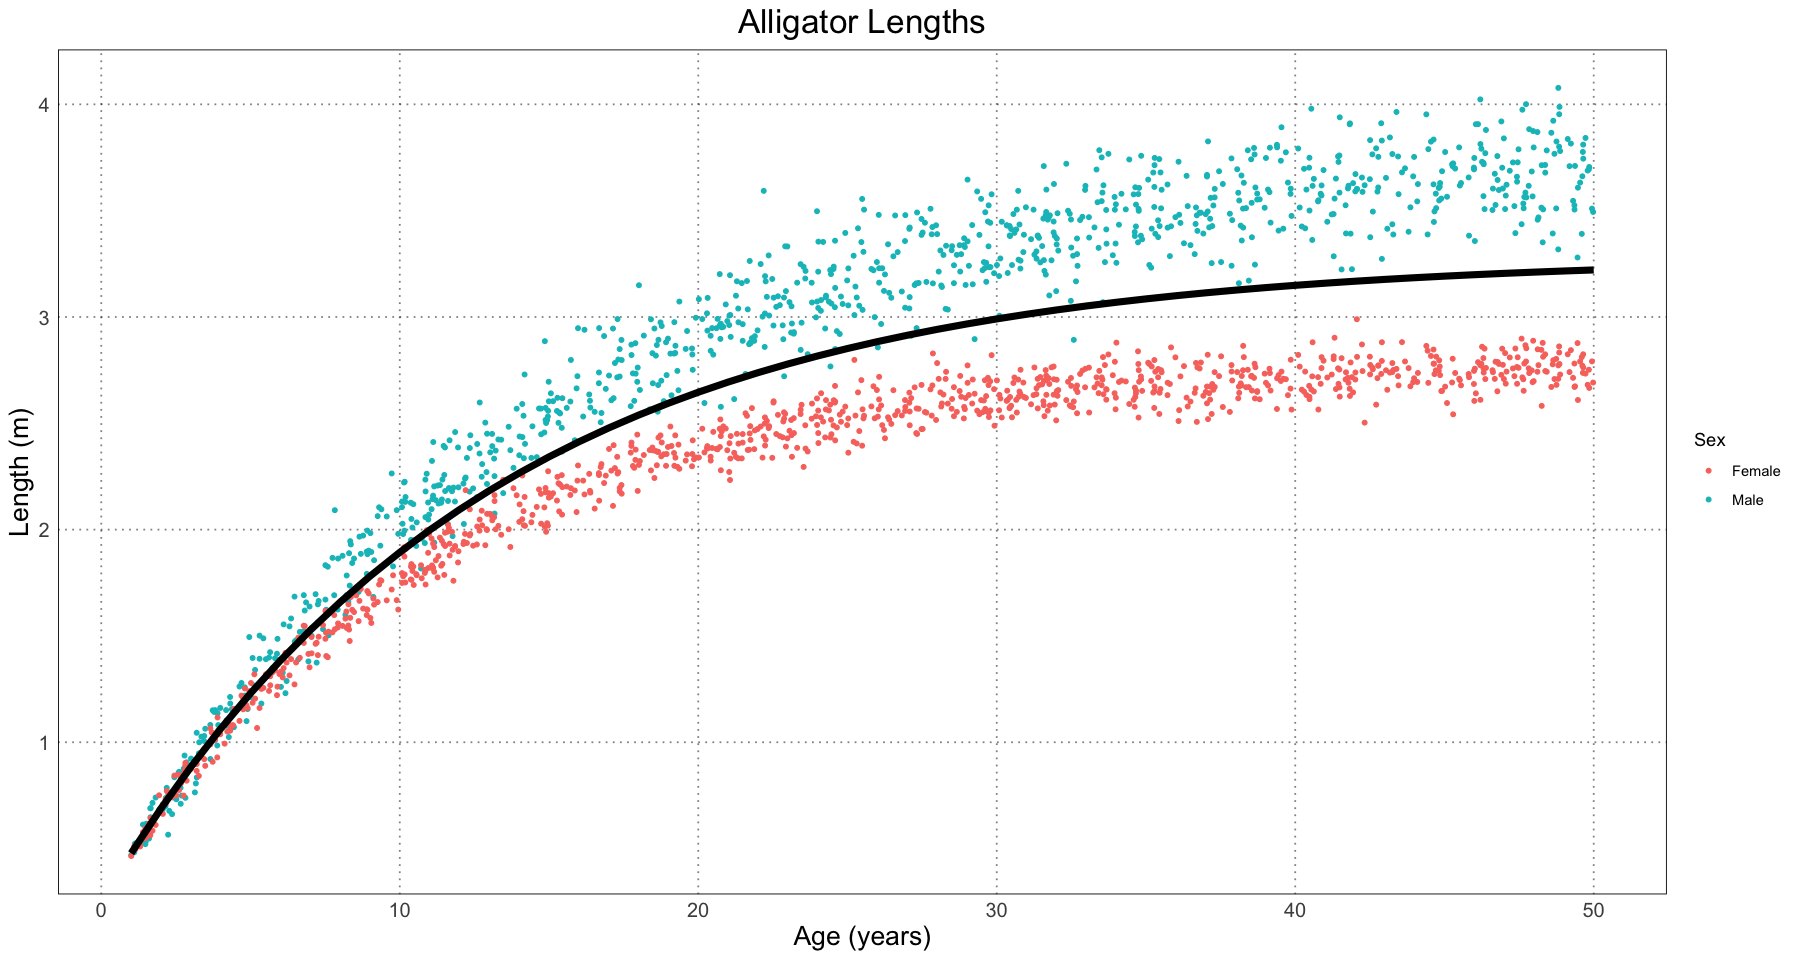

In [30]:
t <- seq(1, ALLIGATOR_MAX_LIFESPAN, by=1)
predicted_lengths <- generalized_von_bertalanffy(t, L = cc[['L']], A = cc[['A']], K = cc['K'])

alligator_plot +
    geom_line(data = data.frame(t = t, length = predicted_lengths), mapping = aes(t, length), linewidth = 2)

In order to assign the sex (remember, we're pretending we don't already know that), we need to look at the residuals as compared to the combined fit model. Luckily, our `nls` object has those pre-computed.

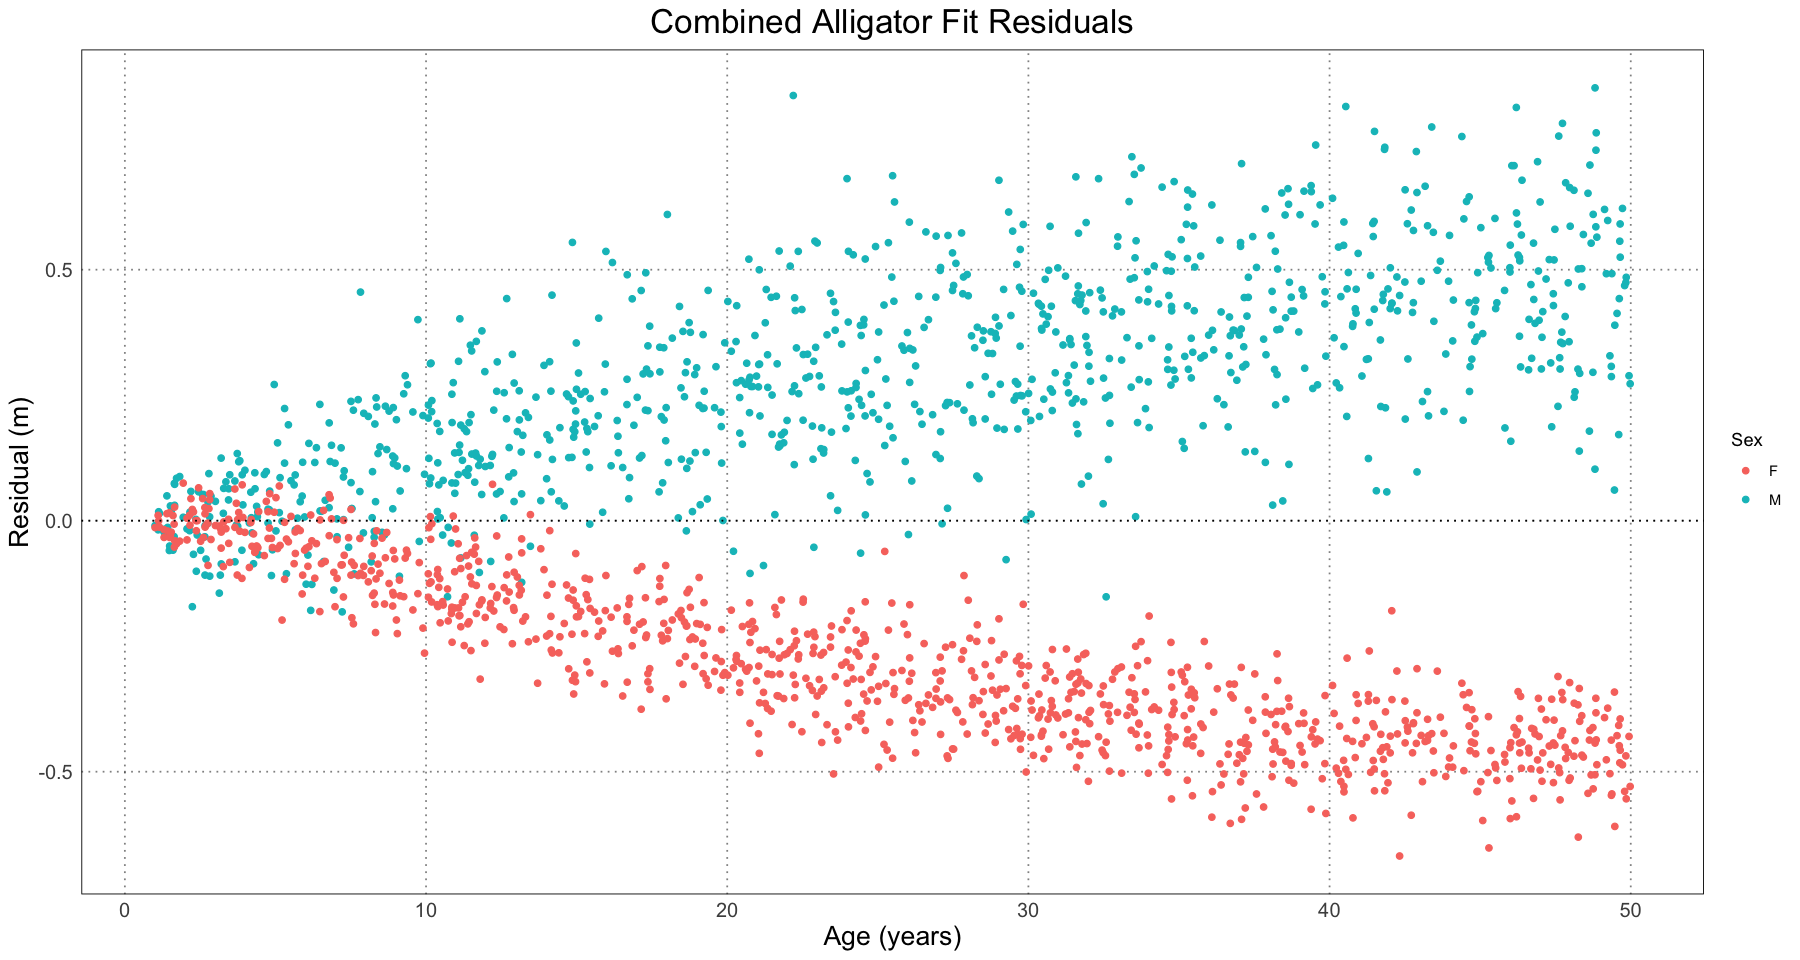

In [37]:
residuals <- residuals(alligator_combined_curve_fit)
plot_df <- data.frame(t = alligator_df$t, residual = residuals, sex = alligator_df$sex)
ggplot(plot_df, aes(t, residual)) +
    geom_point(aes(colour = sex)) +
    geom_hline(yintercept = 0, linetype = 'dotted') +
    custom_theme() +
    labs(title = 'Combined Alligator Fit Residuals', x = 'Age (years)', y = 'Residual (m)', colour = "Sex")


This plot has several features which we could have predicted from the earlier one. First of all, we see that the residuals are close to zero for young alligators and increase over time as the lengths diverge. Secondly, we see that the male alligators almost invariably have a positive residual and female ones have a negative one, again as we predicted.

We can also see from the residuals plot that our model is not a good one - we have clear divergence, among other problems. However, we're not too concerned about that - we know it's not a good model; we're just using this as an initial step to fit a better one (one where the males and females have their own curves).

The next thing we're going to do is to 'predict' the sex of each individual by seeing if its residual is positive or negative. Somewhat arbitrarily, we'll assign positive residuals to being male and negative ones to be being female.

In [39]:
alligator_df$residuals <- residuals(alligator_combined_curve_fit)
alligator_df$predicted_sex <- ifelse(alligator_df$residuals > 0, "M", "F")

Now let's plot the data, highlighting where the predicted sex is incorrect.

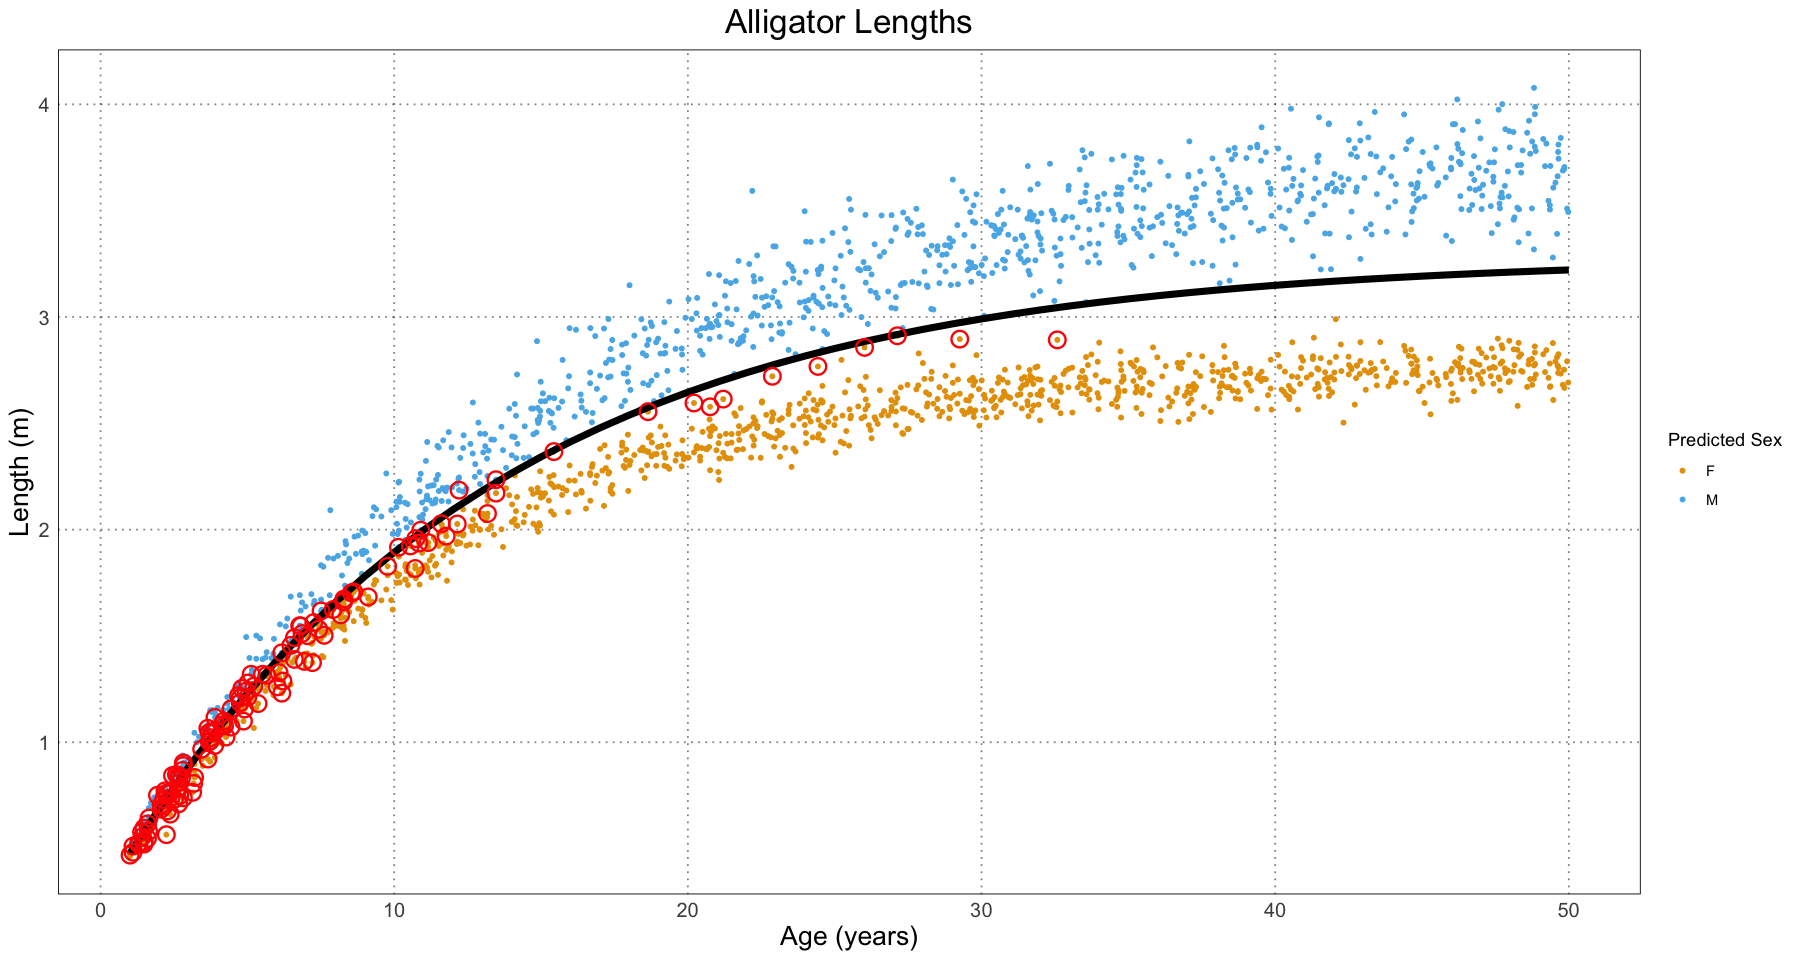

In [53]:
ggplot(alligator_df, aes(t, length)) +
    geom_point(aes(colour = predicted_sex), size = 1) +
    labs(title = "Alligator Lengths", x = "Age (years)", y = "Length (m)", colour = "Predicted Sex") +
    scale_colour_manual(values = c("#E69F00", "#56B4E9"), labels = c("F", "M")) +
    geom_line(data = data.frame(t = t, length = predicted_lengths), mapping = aes(t, length), linewidth = 2) +
    geom_point(data = alligator_df[alligator_df$sex != alligator_df$predicted_sex, ], aes(t, length), pch = 21, fill = NA, colour = "red", stroke = 1, size = 4) +
    custom_theme()

As expected, the classifier is worse for younger alligators (where the sizes are basically the same) and much better for the older ones, where there is a clearer separation.

As the authors themselves note, determination of sex is one of the toughest parts of this whole process and would be a fruitful area for further research. This method has the advantage of being easy to understand and computationally easy. It is also surprisingly accurate.

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


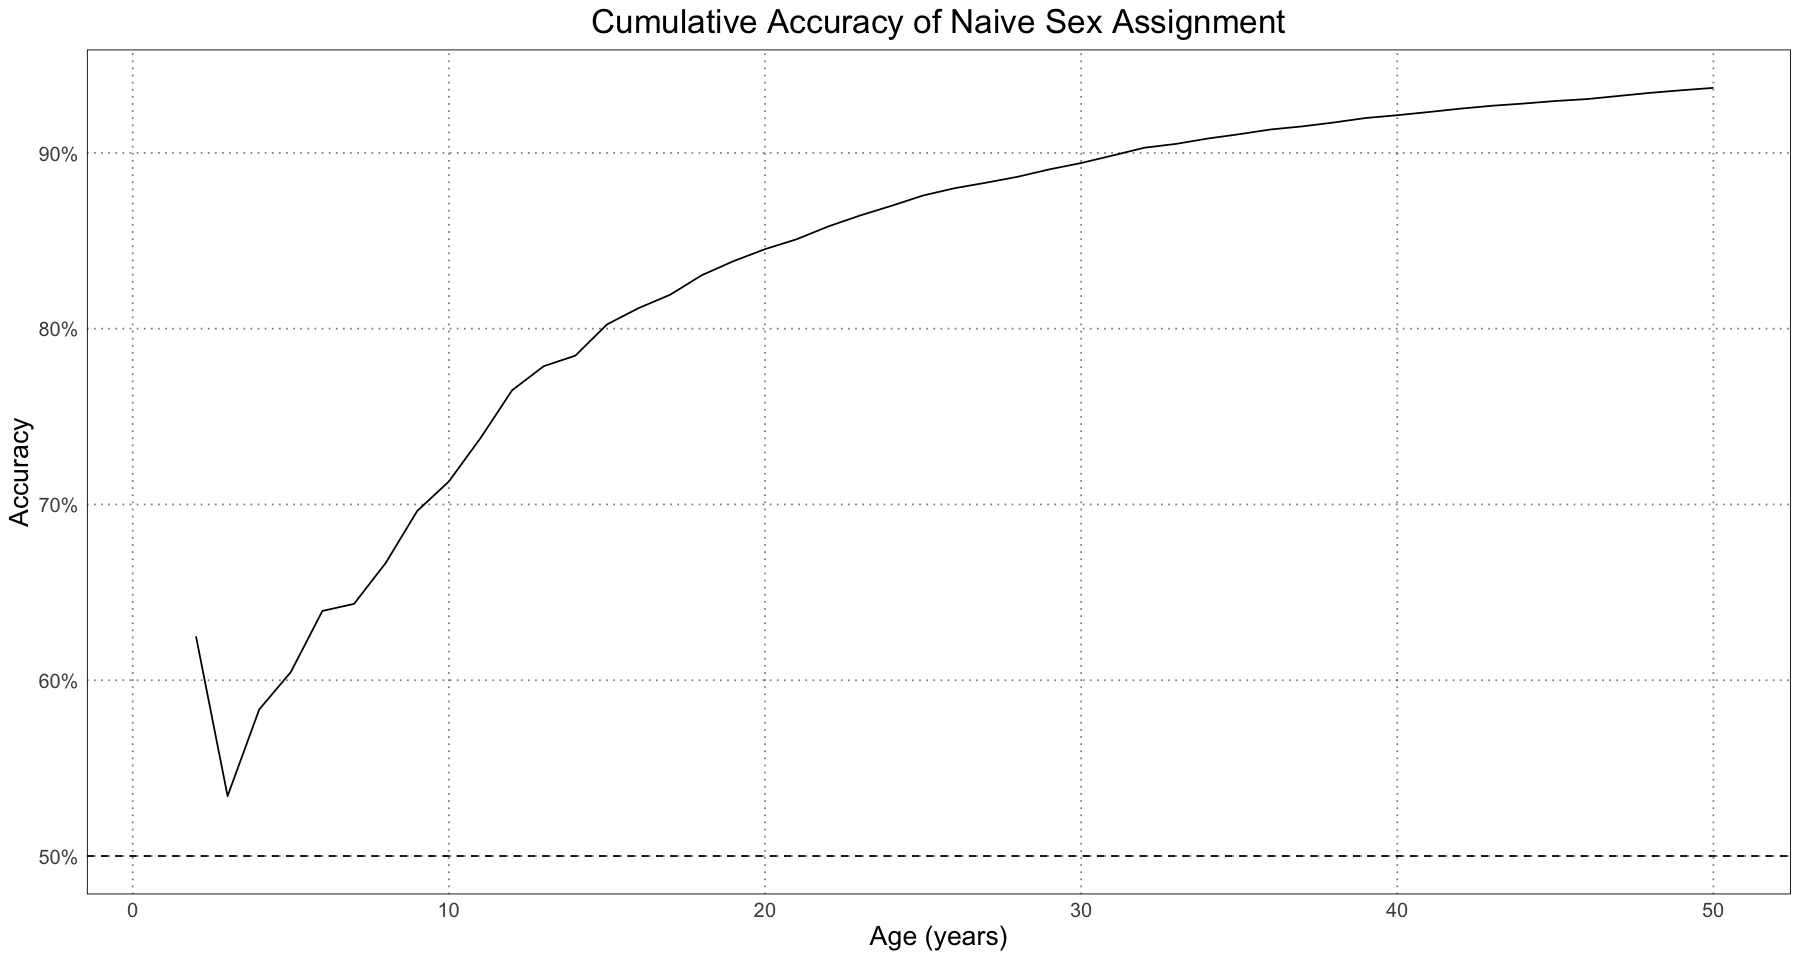

In [75]:
sex_accuracy_df <- data.frame(t = numeric(), accuracy = numeric())
for (threshold_t in 1:ALLIGATOR_MAX_LIFESPAN) {
    relevant <- alligator_df[alligator_df$t <= threshold_t, ]
    accuracy <- sum(relevant$sex == relevant$predicted_sex) / nrow(relevant)
    sex_accuracy_df <- rbind(sex_accuracy_df, data.frame(t = threshold_t, accuracy = accuracy))
}
ggplot(sex_accuracy_df, aes(t, accuracy)) +
    geom_line() +
    geom_hline(yintercept = 0.5, linetype = 'dashed') +
    labs(title = "Cumulative Accuracy of Naive Sex Assignment", x = "Age (years)", y = "Accuracy") +
    scale_y_continuous(labels = scales::percent) +
    custom_theme()

At all ages the naive classifier is better than random (the 50% dashed line) and for the entire population as a whole the accuracy is above 90%, which is pretty good.

The next thing the paper's authors did is look at how the accuracy of the classifier fared over different effect sizes, where here an effect size of 0 means that there is no dimorphism, effect size of 1 means the naturally occurring dimorphism between male and female alligators, and effect size 2 means twice as much dimorphism as is naturally present.

In [107]:
# E is the effect size
generate_simulated_male_alligator_parameters <- function(effect_size) {
    list(
        L = 2.78 + effect_size,
        A = 0.91 + 0.0297 * effect_size,
        K = 0.0926 - 0.02287 * effect_size
    )
}

generate_simulated_male_lengths <- function(t, E) {
    params <- generate_simulated_male_alligator_parameters(E)
    means <- generalized_von_bertalanffy(t, params[['L']], params[['A']], params[['K']])
    # as in the paper, we use the male sd
    rnorm(length(t), mean = means, sd = generate_male_alligator_sigma(means))
}

generate_simulated_female_lengths <- function(t) {
    means <- generate_female_alligator_mean_lengths(t)
    # as in the paper, we use the male sd
    rnorm(length(t), mean = means, sd = generate_male_alligator_sigma(means))
}

accuracy_df <- data.frame(E = numeric(), accuracy = numeric(), sample_size = numeric())
for(sample_size in seq(5, 130, by = 10)) {
    for (E in seq(0, 2, length.out = 10)) {
        t <- runif(sample_size, 1, ALLIGATOR_MAX_LIFESPAN)
        female_sample <- generate_simulated_female_lengths(t)
        male_sample <- generate_simulated_male_lengths(t, E)

        combined_data <- data.frame(t = rep(t, 2), length = c(female_sample, male_sample), sex = rep(c("F", "M"), each = length(t)))

        # start at the female ones - will mean that it takes longer to converge, but that's OK
        initial_parameters <- list(L = 2.78, A = 0.91, K = 0.0926)

        combined_curve_fit <- nls(length ~ generalized_von_bertalanffy(t, L, A, K), data = combined_data, start = initial_parameters)
        cc <- coef(combined_curve_fit)
        combined_data$residuals <- residuals(combined_curve_fit)
        combined_data$predicted_sex <- ifelse(combined_data$residuals > 0, "M", "F")
        accuracy <- sum(combined_data$sex == combined_data$predicted_sex) / nrow(combined_data)
        # since sample_size is for each of male and females, the total sample size is twice that
        accuracy_df <- rbind(accuracy_df, data.frame(E = E, accuracy = accuracy, sample_size = sample_size * 2))
    }
}
head(accuracy_df)

E         accuracy sample_size
1 0.0000000 1.0      10         
2 0.2222222 0.5      10         
3 0.4444444 0.8      10         
4 0.6666667 0.9      10         
5 0.8888889 0.8      10         
6 1.1111111 0.8      10

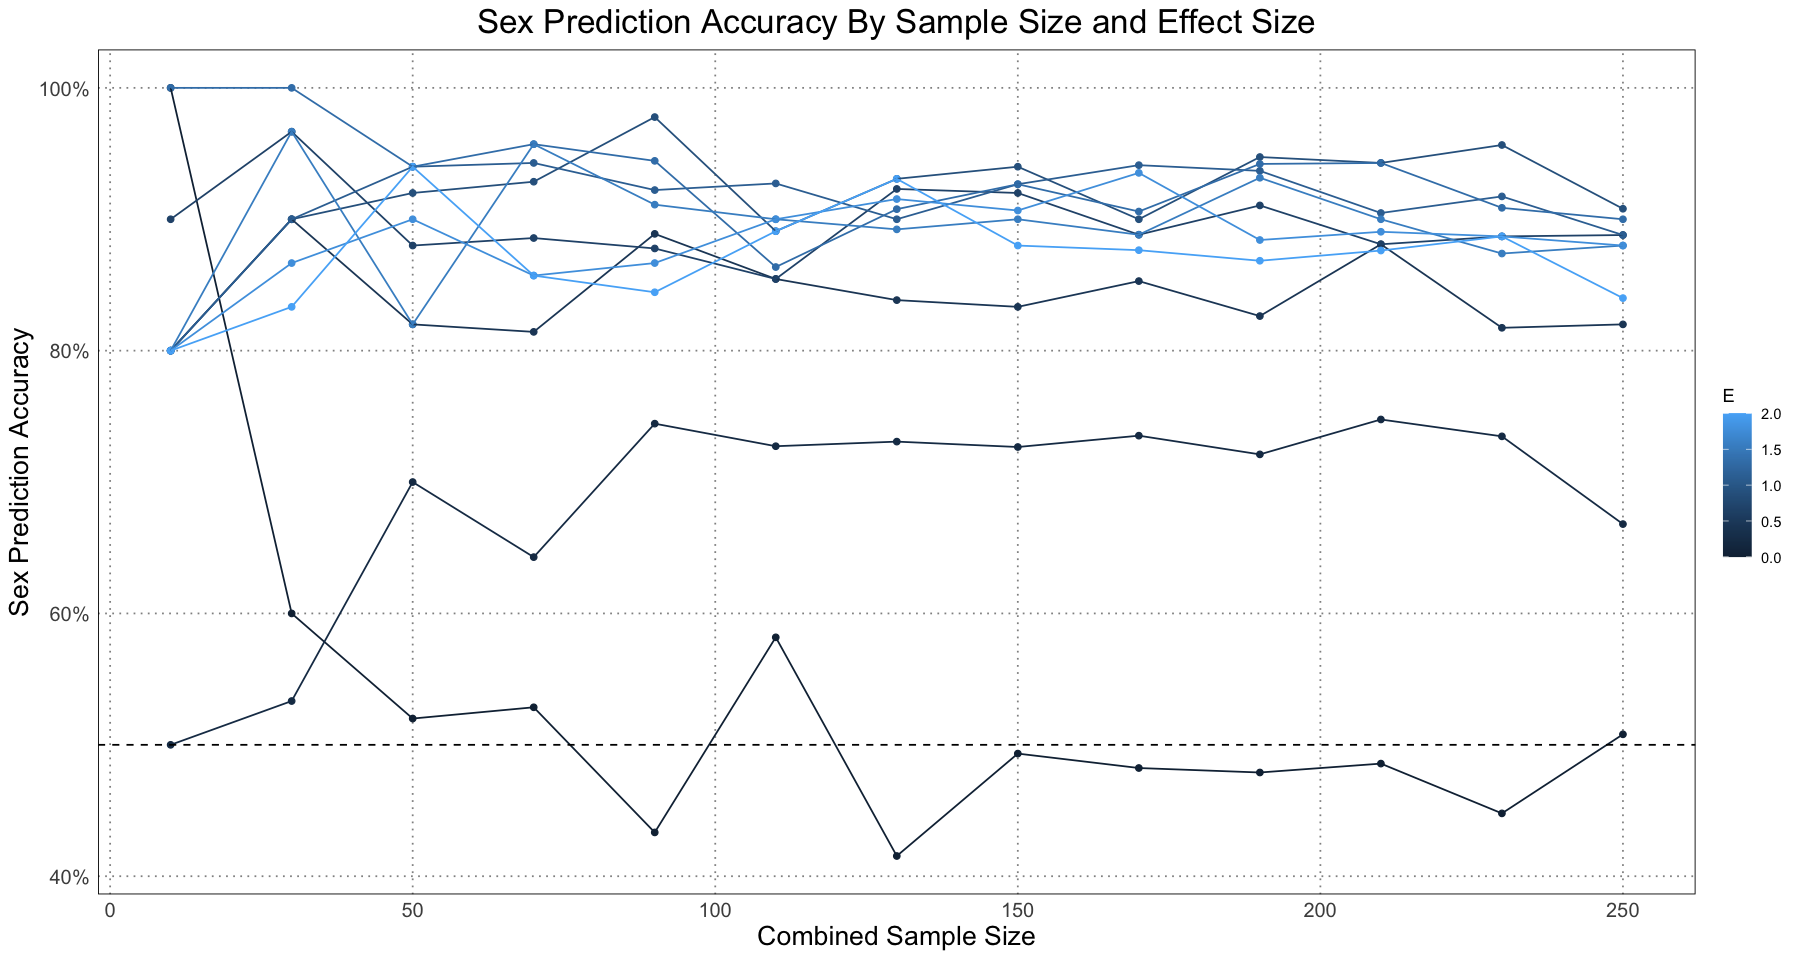

In [108]:
ggplot(accuracy_df, aes(sample_size, accuracy, colour = E, group = E)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.5, linetype = 'dashed') +
    labs(x = 'Combined Sample Size', y = 'Sex Prediction Accuracy', title = 'Sex Prediction Accuracy By Sample Size and Effect Size') +
    scale_y_continuous(labels = scales::percent) +
    custom_theme()

Since this is a graph of a single run for each sample size and effect size there is a fair amount of variation. However, the pattern is clear - as long as there is some amount of dimorphism, the accuracy for even small sample sizes can be quite good.

This graph is based on Figure 7 in Saitta, et. al. (2020), but I have not broken the accuracy up by sex but rather looked at the combined accuracy instead. Nonetheless, the results are essentially the same.

Since there is so much variation caused by just having a single run, let's repeat this a number of times for each effect size and sample size and plot the results using a contour plot to get a better idea for what's happening.

In [132]:
NUM_REPETITIONS <- 100
repeated_accuracy_df <- data.frame(E = numeric(), accuracy = numeric(), sample_size = numeric())
# for (sample_size in c(5)) {
for(sample_size in seq(5, 130, by = 10)) {
    for (E in seq(0, 2, by = 0.1)) {
        sum_accuracies <- 0
        for (rep_number in 1:NUM_REPETITIONS) {
            t <- runif(sample_size, 1, ALLIGATOR_MAX_LIFESPAN)
            female_sample <- generate_simulated_female_lengths(t)
            male_sample <- generate_simulated_male_lengths(t, E)

            combined_data <- data.frame(t = rep(t, 2), length = c(female_sample, male_sample), sex = rep(c("F", "M"), each = length(t)))

            # start at the mean of the parameters
            male_params <- generate_simulated_male_alligator_parameters(E)
            initial_parameters <- list(L = mean(c(2.78, male_params[['L']])), A = mean(c(0.91, male_params[['A']])), K = mean(c(0.0926, male_params[['K']])))

            tryCatch({
                # set tol = 100 to avoid problems with low effect size and samples -> the data are too sparse to set a good approximation of the growth curve. We're OK with that.
                combined_curve_fit <- nls(length ~ generalized_von_bertalanffy(t, L, A, K), data = combined_data, start = initial_parameters, control = list(tol = 100))
            }, error = function(cond){
                message(paste("Error fitting data"))
                message(conditionMessage(cond))
                message(paste('sample_size', sample_size))
                message(paste('effect size', E))
                message(paste('rep number', rep_number))
                next
            })
            cc <- coef(combined_curve_fit)
            combined_data$residuals <- residuals(combined_curve_fit)
            combined_data$predicted_sex <- ifelse(combined_data$residuals > 0, "M", "F")
            accuracy <- sum(combined_data$sex == combined_data$predicted_sex) / nrow(combined_data)
            sum_accuracies <- sum_accuracies + accuracy
        }
        # since sample_size is for each of male and females, the total sample size is twice that
        repeated_accuracy_df <- rbind(repeated_accuracy_df, data.frame(E = E, accuracy = sum_accuracies / NUM_REPETITIONS, sample_size = sample_size * 2))
    }
}
head(repeated_accuracy_df)
# repeated_accuracy_df

E   accuracy sample_size
1 0.0 0.482    10         
2 0.1 0.577    10         
3 0.2 0.672    10         
4 0.3 0.751    10         
5 0.4 0.801    10         
6 0.5 0.869    10

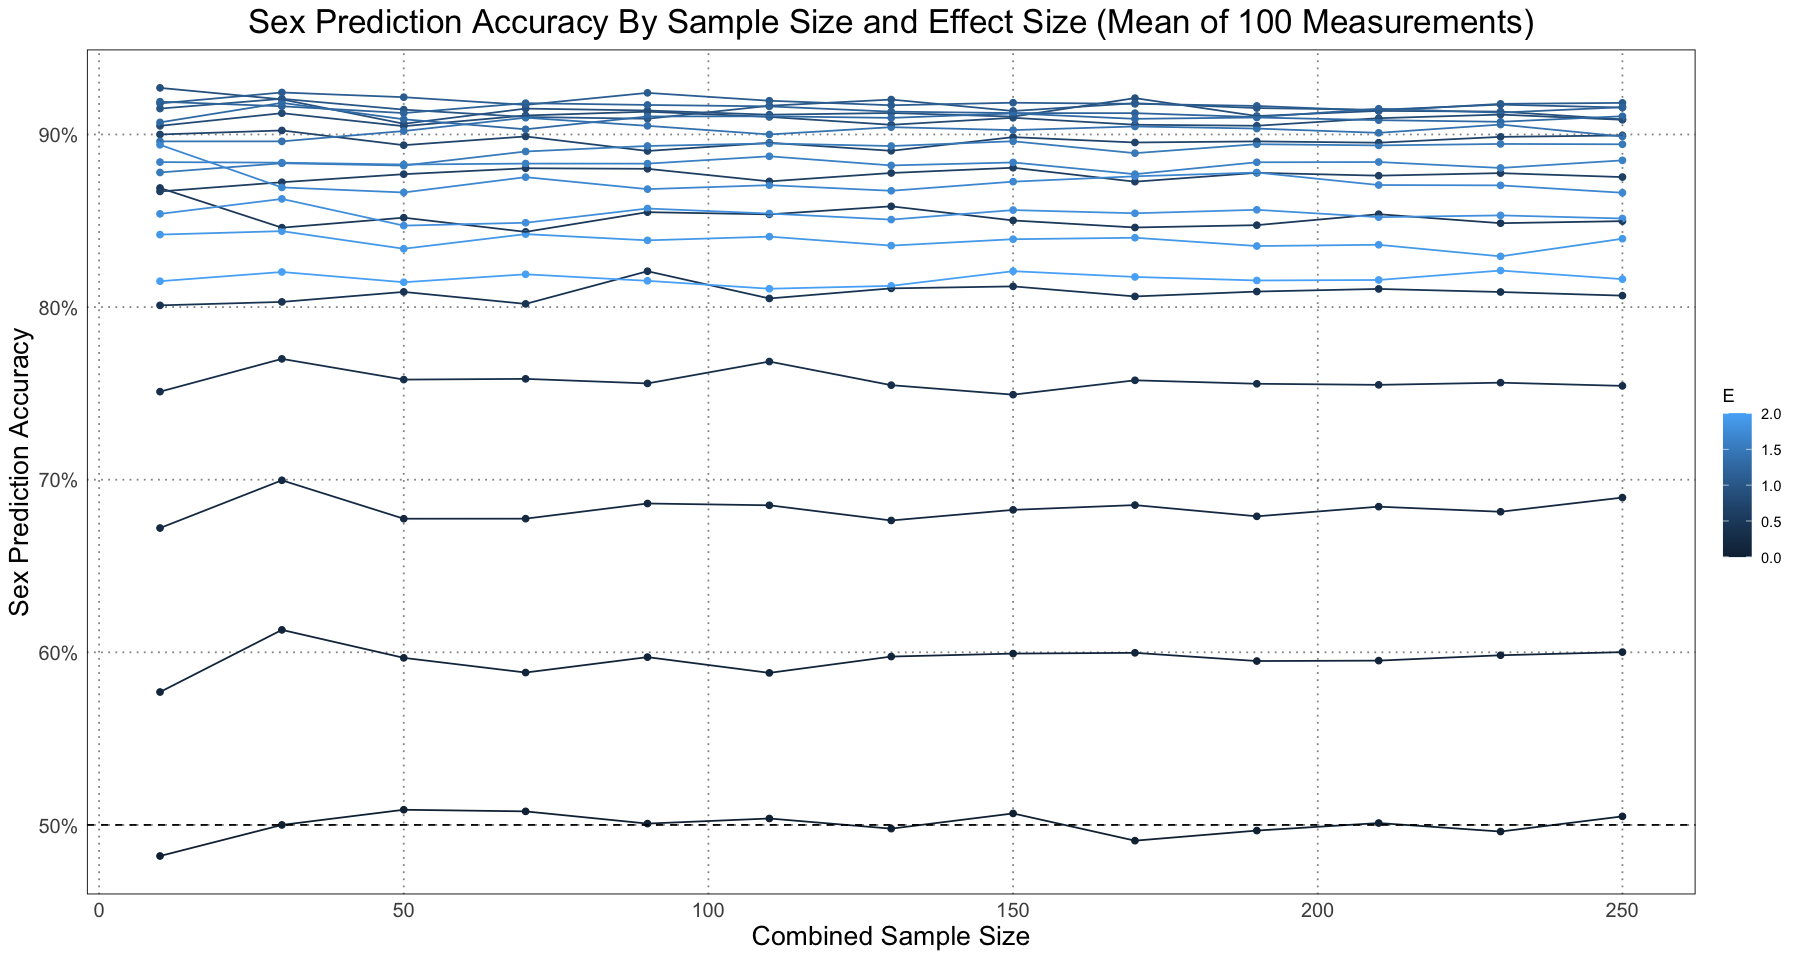

In [135]:
ggplot(repeated_accuracy_df, aes(sample_size, accuracy, group = E, colour = E)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.5, linetype = 'dashed') +
    labs(x = 'Combined Sample Size', y = 'Sex Prediction Accuracy', title = 'Sex Prediction Accuracy By Sample Size and Effect Size (Mean of 100 Measurements)') +
    scale_y_continuous(labels = scales::percent) +
    custom_theme()

As we expect, if there is no effect size then the naive classifier is right about 50% of the time (if there's no difference, then we are basically guessing - there's no difference to go on!). As the effect size increases, so does our accuracy.

Of course, all of this analysis was done with a sex ratio of 1:1 - we always had the same number of male and female samples! In reality, this might not be the case. The authors go on to demonstrate that the accuracy of the naive classifier is harmed by the presence of ratios different from 1 - that is, if there is a skew in the sex ratio then the accuracy suffers. I'm going to skip recreating that analysis.


Although the general pattern is that the accuracy increases, if you look closely at the graph you can notice that actually for large values of the effect size, the accuracy seems to *decrease*. By looking at the values for a specific value of the sample size, we can see this more clearly.

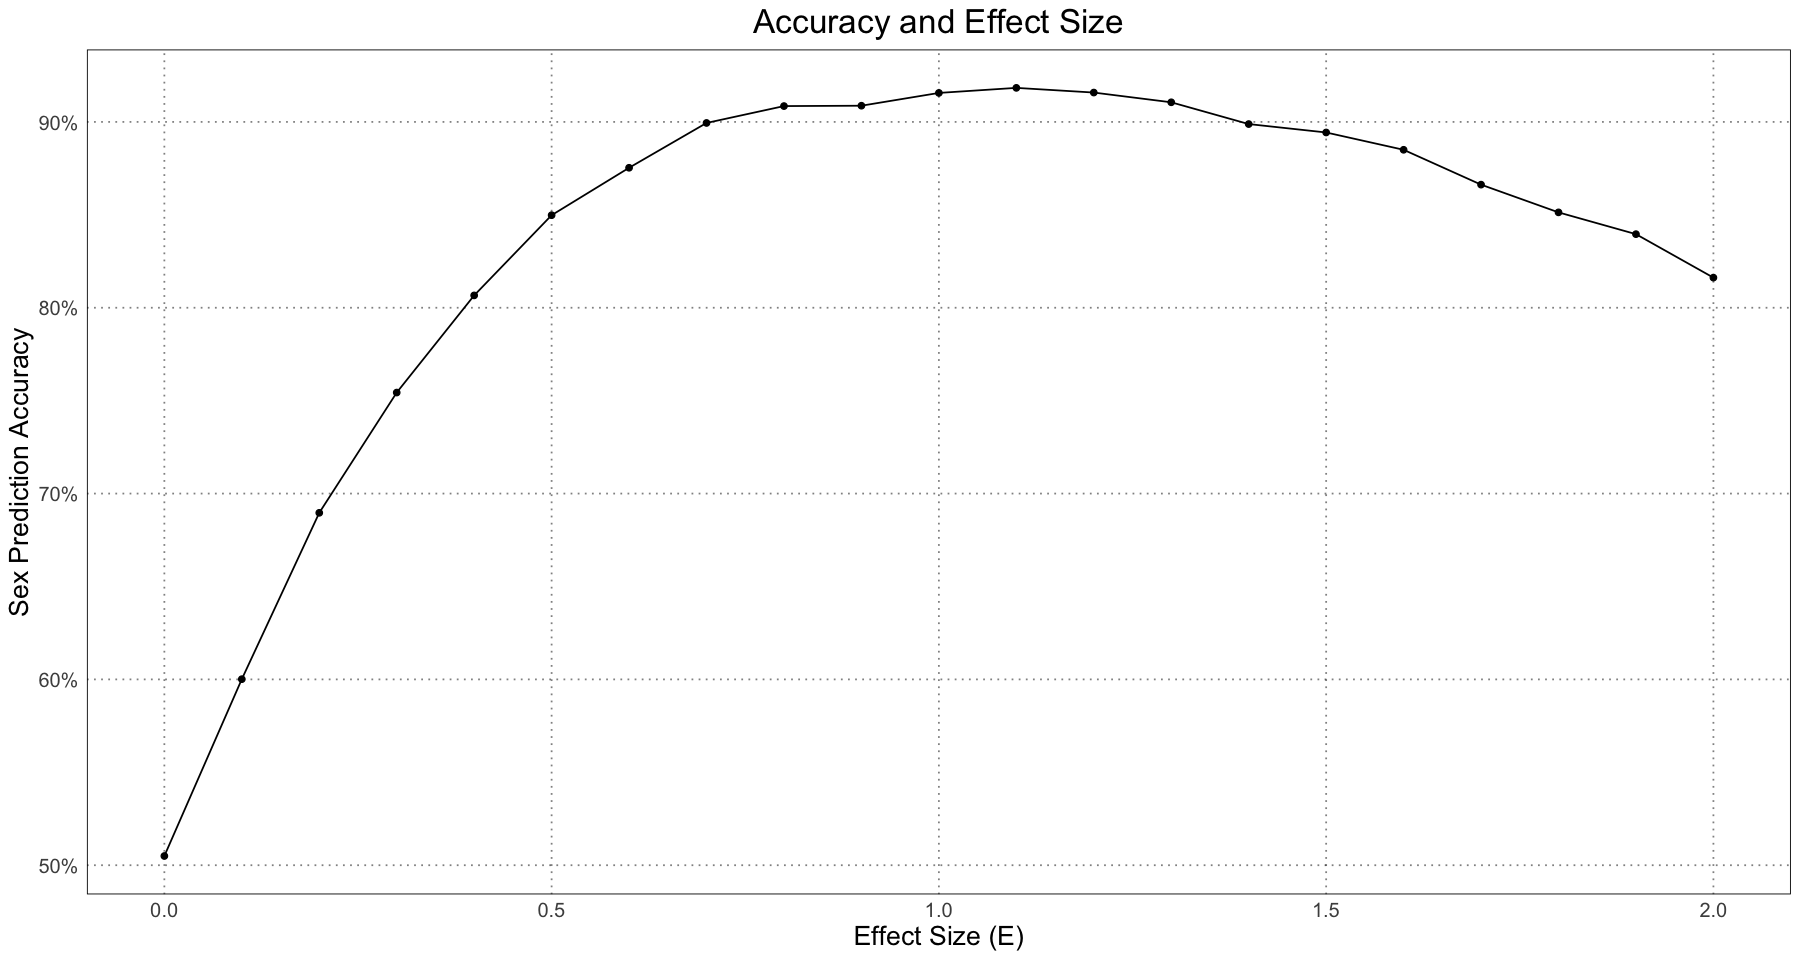

In [139]:
ggplot(repeated_accuracy_df[repeated_accuracy_df$sample_size == 250, ], aes(E, accuracy)) +
    geom_point() +
    geom_line() +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Accuracy and Effect Size", x = "Effect Size (E)", y = "Sex Prediction Accuracy") +
    custom_theme()

In order to see what's going on, let's take a look at a few plots for the different effect sizes.

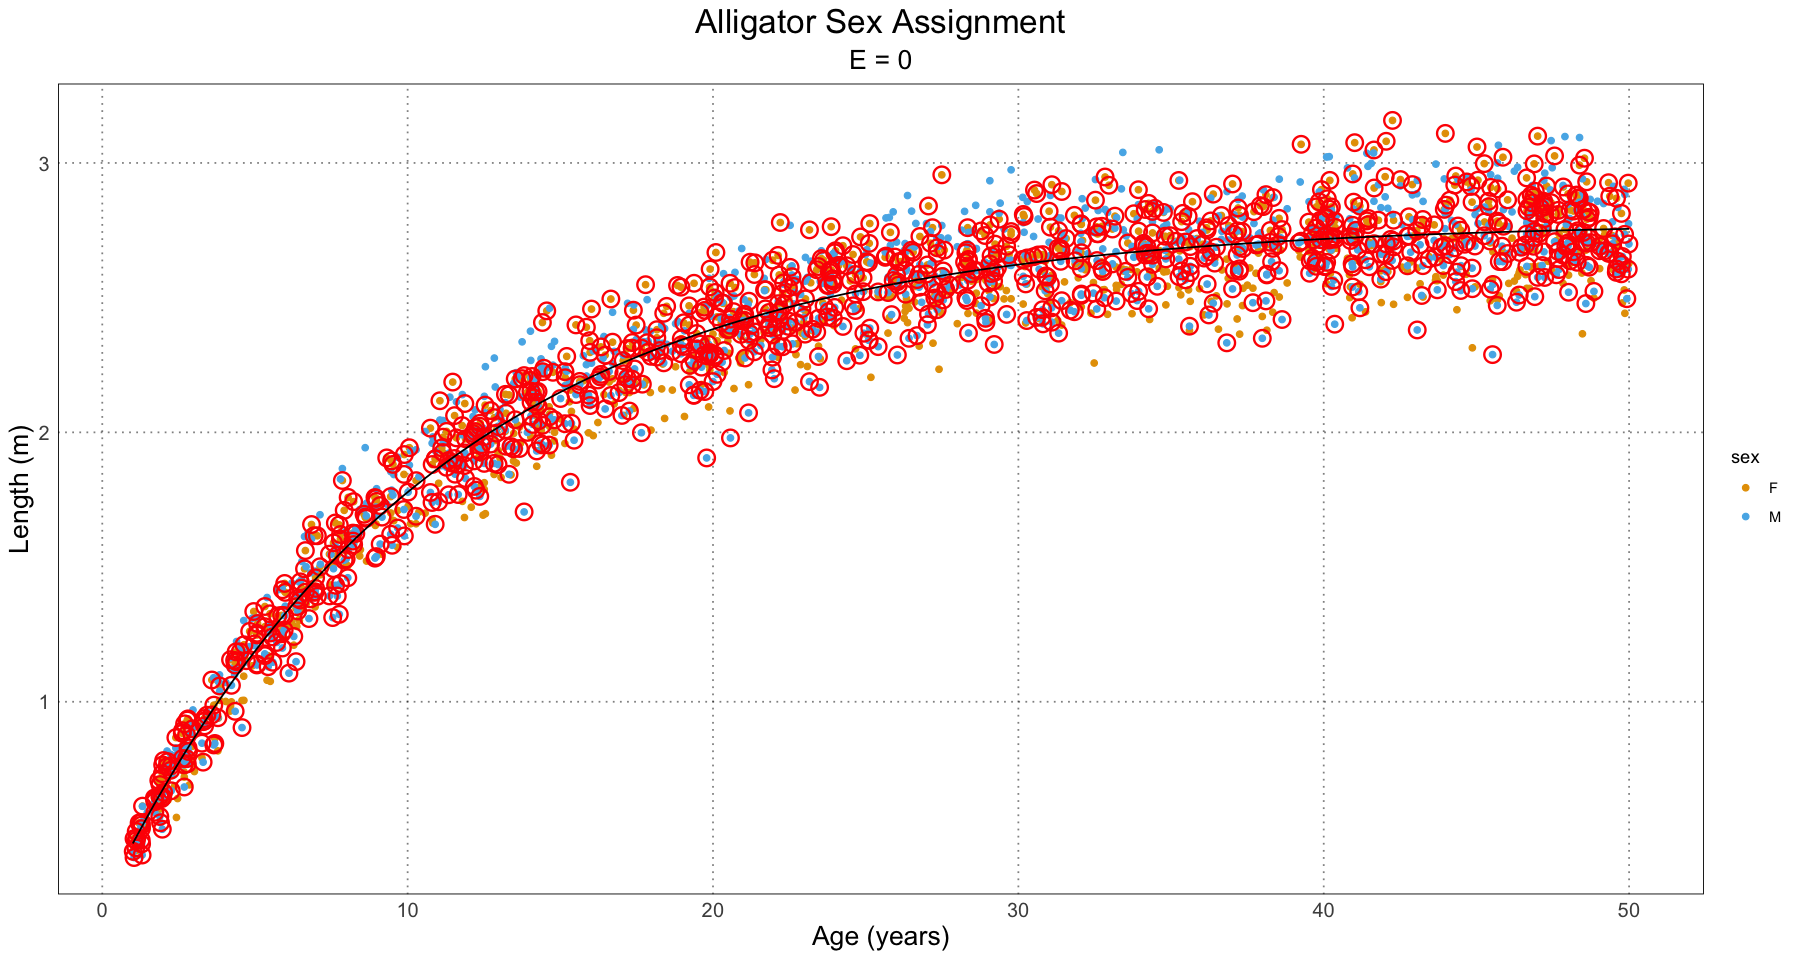

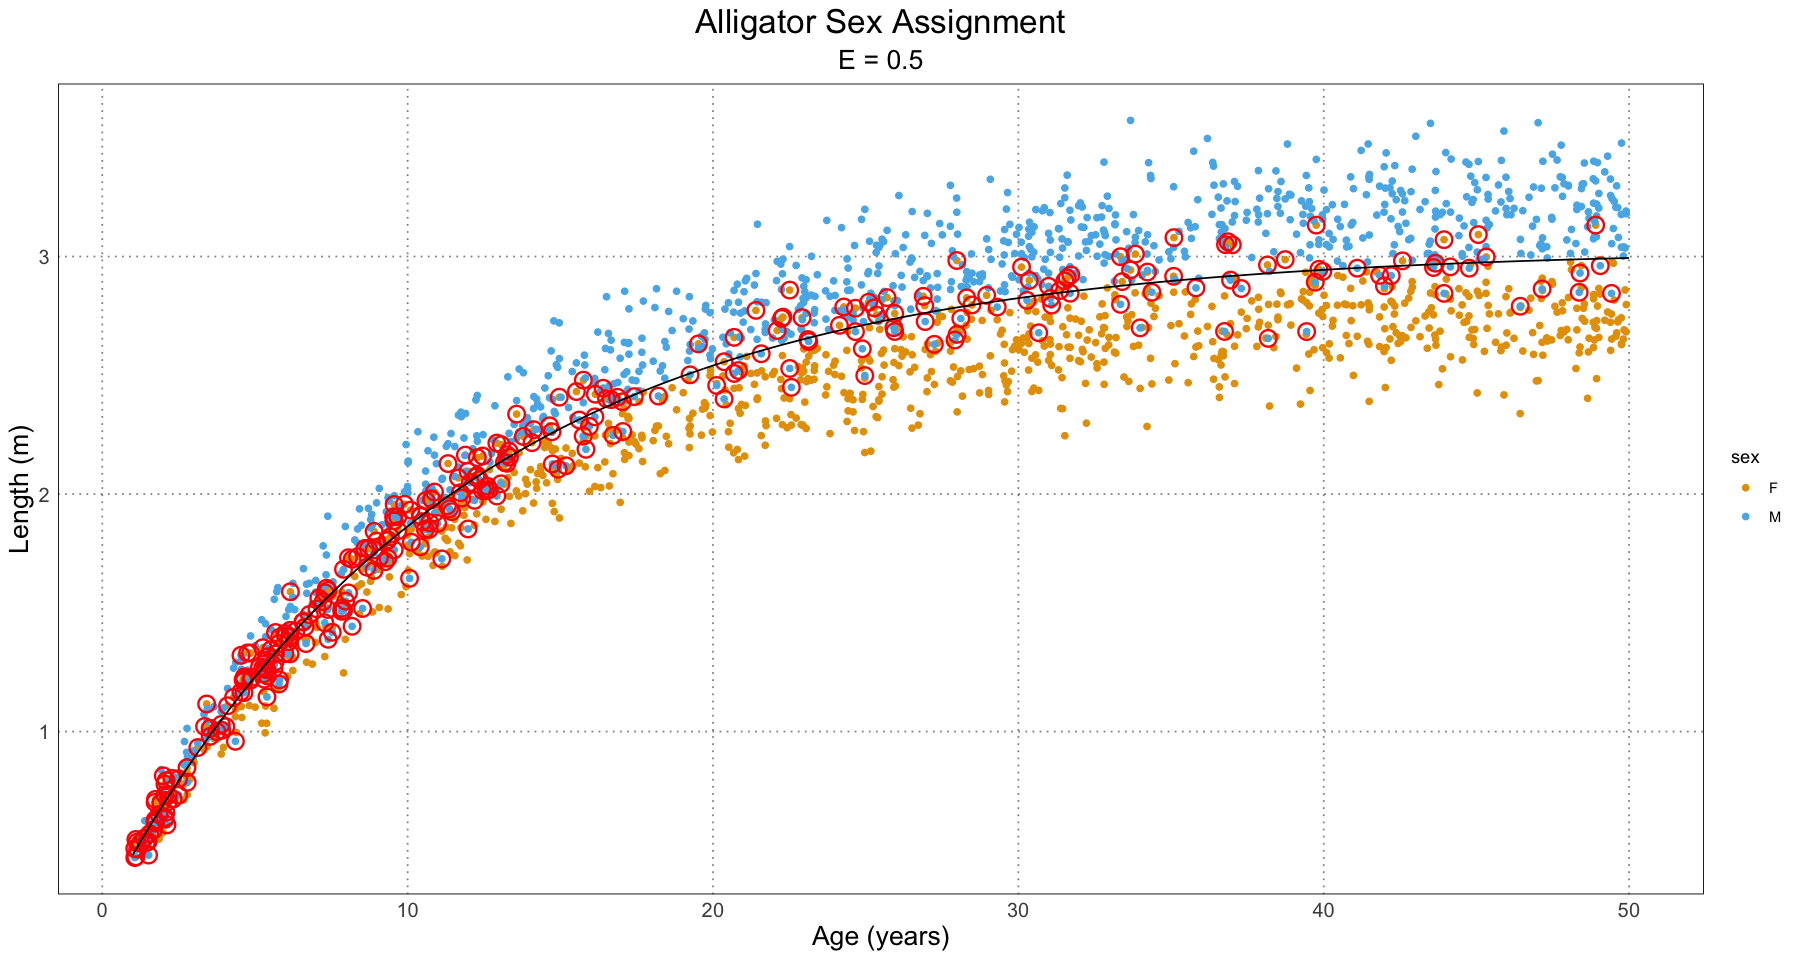

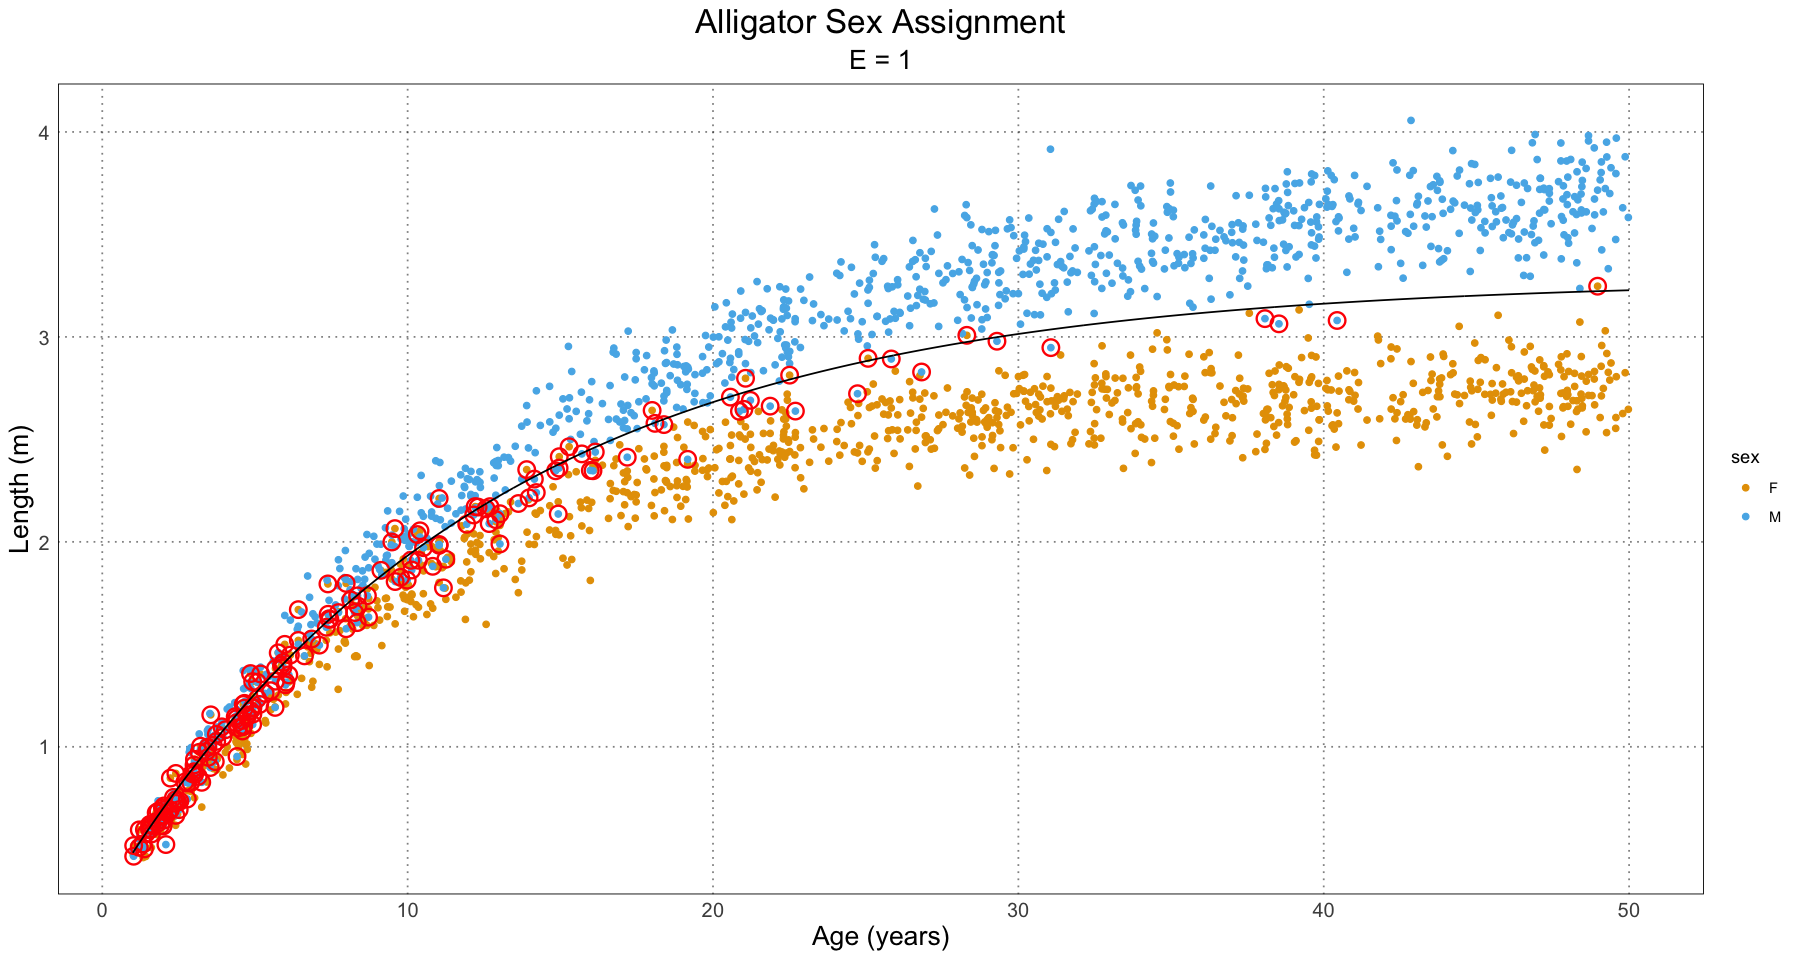

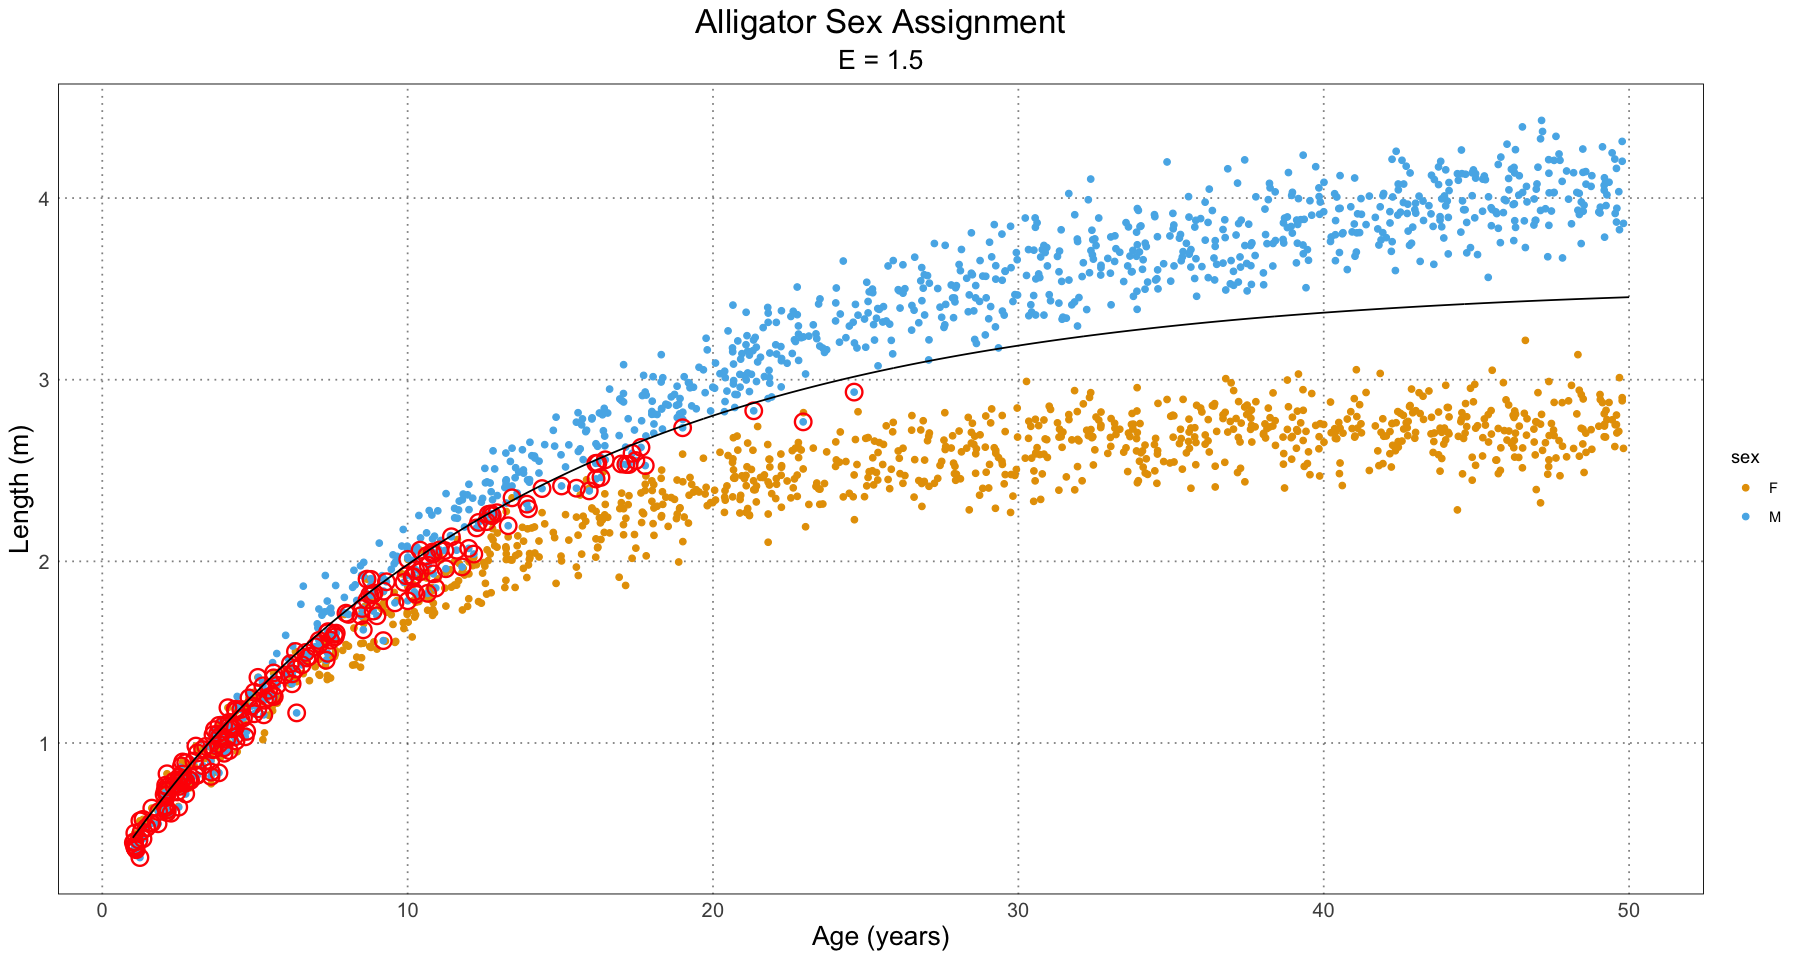

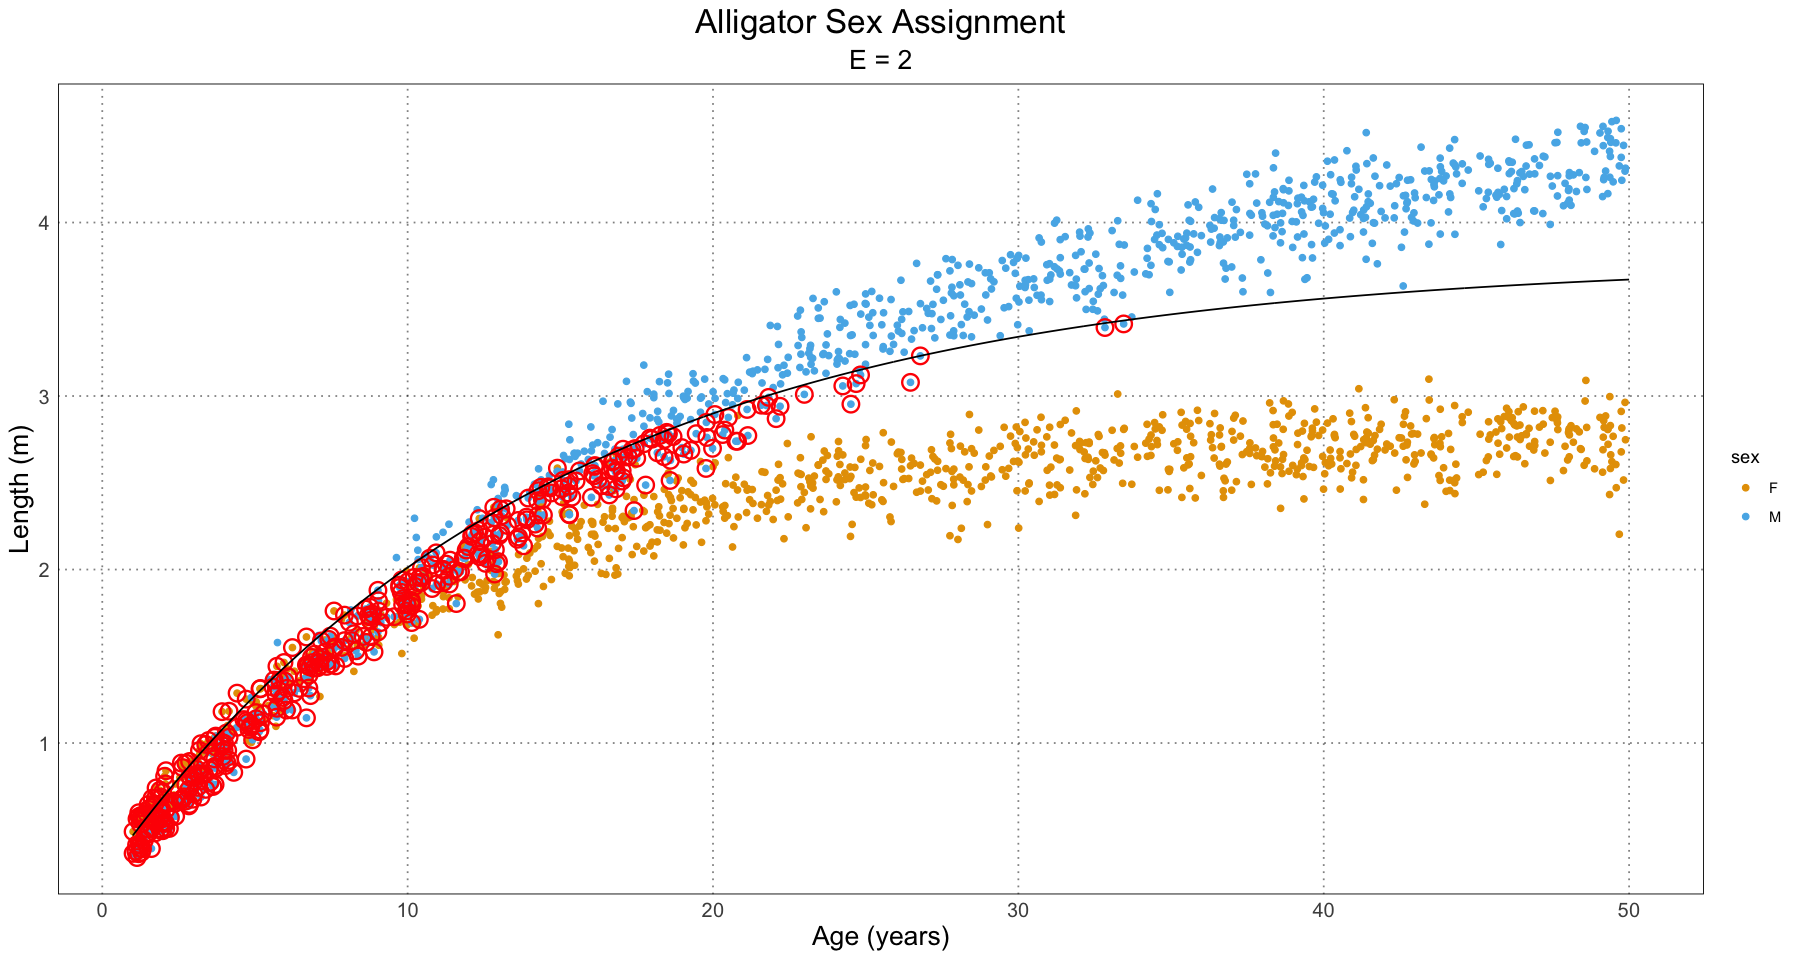

In [148]:
sample_size <- 1e3
for (E in seq(0, 2, by = 0.5)) {
    t <- runif(sample_size, 1, ALLIGATOR_MAX_LIFESPAN)
    female_sample <- generate_simulated_female_lengths(t)
    male_sample <- generate_simulated_male_lengths(t, E)

    combined_data <- data.frame(t = rep(t, 2), length = c(female_sample, male_sample), sex = rep(c("F", "M"), each = length(t)), E = E)

    # start at the mean of the parameters
    male_params <- generate_simulated_male_alligator_parameters(E)
    initial_parameters <- list(L = mean(c(2.78, male_params[['L']])), A = mean(c(0.91, male_params[['A']])), K = mean(c(0.0926, male_params[['K']])))
    
    tryCatch({
        # set tol = 100 to avoid problems with low effect size and samples -> the data are too sparse to set a good approximation of the growth curve. We're OK with that.
        combined_curve_fit <- nls(length ~ generalized_von_bertalanffy(t, L, A, K), data = combined_data, start = initial_parameters, control = list(tol = 100))
    }, error = function(cond){
        message(paste("Error fitting data"))
        message(conditionMessage(cond))
        message(paste('sample_size', sample_size))
        message(paste('effect size', E))
        message(paste('rep number', rep_number))
        next
    })
    cc <- coef(combined_curve_fit)
    combined_data$residuals <- residuals(combined_curve_fit)
    combined_data$predicted_sex <- ifelse(combined_data$residuals > 0, "M", "F")
    
    # curve data - graph the computed combined growth curve
    curve_t <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 1e3)
    curve_length <- generalized_von_bertalanffy(curve_t, L = cc[['L']], A = cc[['A']], K = cc[['K']])
    curve_df <- data.frame(t = curve_t, length = curve_length, E = E)

    p <- ggplot(combined_data, aes(t, length)) +
        geom_point(aes(colour = sex)) +
        scale_colour_manual(values = c("#E69F00", "#56B4E9"), labels = c("F", "M")) +
        geom_point(data = combined_data[combined_data$sex != combined_data$predicted_sex, ], aes(t, length), pch = 21, fill = NA, colour = "red", stroke = 1, size = 4) +
        geom_line(data = curve_df, aes(t, length)) +
        labs(title = "Alligator Sex Assignment", subtitle = paste("E =", E), x = "Age (years)", y = "Length (m)") +
        custom_theme()
    print(p)
}


From this, we can have a good guess at the problem - our initial guess as to the combined growth curve is becoming so bad that it is misclassifying many of the younger individuals. We have a fit problem! For now, this is not something I'm concerned about. A fruitful area for further research would be to fit a different family of curve to the population as a whole as compared to the male and female populations. For instance, we could fit some sort of polynomial (truncated Taylor series) to the curve (selected on some sort of information criterion).

Bottom line: this naive classifier, while it certaily has some faults, works surprisingly well. As the authors admit, methods to more accurately predict sex will be key to further advancement in this.

The next thing we're going to do is to fit curves individually to the male and female (predicted, not actual) individuals. Once we have these parameters, we will be able to give a numeric estimate of the difference in the different sexes! Let's start by fitting the curve to the actual alligator sizes.

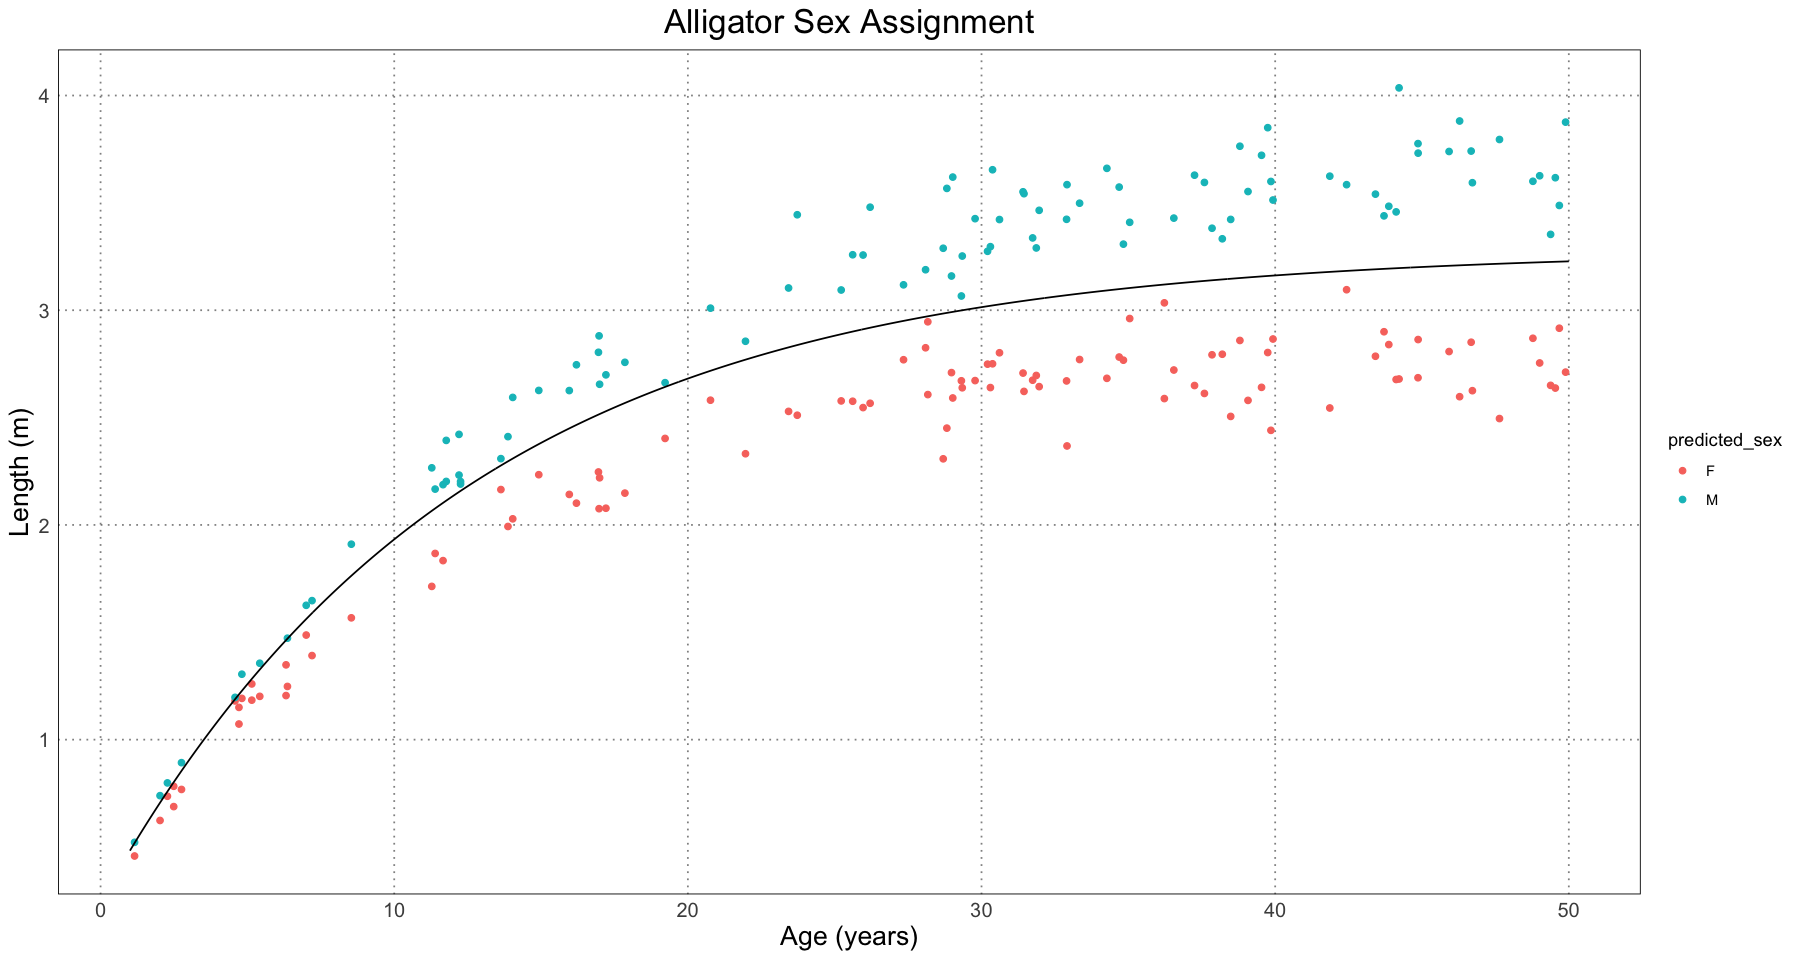

In [151]:
E <- 1 # use the naturally occurring effect size
t <- runif(1e2, 1, ALLIGATOR_MAX_LIFESPAN)
female_sample <- generate_simulated_female_lengths(t)
male_sample <- generate_simulated_male_lengths(t, E)

combined_data <- data.frame(t = rep(t, 2), length = c(female_sample, male_sample), sex = rep(c("F", "M"), each = length(t)), E = E)

# start at the mean of the parameters
male_params <- generate_simulated_male_alligator_parameters(E)
initial_parameters <- list(L = mean(c(2.78, male_params[['L']])), A = mean(c(0.91, male_params[['A']])), K = mean(c(0.0926, male_params[['K']])))

tryCatch({
    # set tol = 100 to avoid problems with low effect size and samples -> the data are too sparse to set a good approximation of the growth curve. We're OK with that.
    combined_curve_fit <- nls(length ~ generalized_von_bertalanffy(t, L, A, K), data = combined_data, start = initial_parameters, control = list(tol = 100))
}, error = function(cond){
    message(paste("Error fitting data"))
    message(conditionMessage(cond))
    message(paste('sample_size', sample_size))
    message(paste('effect size', E))
    message(paste('rep number', rep_number))
    next
})
cc <- coef(combined_curve_fit)
combined_data$residuals <- residuals(combined_curve_fit)
combined_data$predicted_sex <- ifelse(combined_data$residuals > 0, "M", "F")

# curve data - graph the computed combined growth curve
curve_t <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 1e3)
curve_length <- generalized_von_bertalanffy(curve_t, L = cc[['L']], A = cc[['A']], K = cc[['K']])
curve_df <- data.frame(t = curve_t, length = curve_length, E = E)

ggplot(combined_data, aes(t, length)) +
    geom_point(aes(colour = predicted_sex)) +
    geom_line(data = curve_df, mapping = aes(t, length)) +
    labs(x = "Age (years)", y = "Length (m)", title = "Alligator Sex Prediction") +
    custom_theme()

## Ruling Out Alternate Hypotheses

The next thing the authors look at is ruling out a wide variety of alternate hypotheses for any observed differences.
1. Controlling for non-sexual variation and polymorphism in populations: this is what we examined earlier when fitting the growth curves, &c.
1. Controlling for ontogenetic variation: largely taken care of by the process of fitting a growth curve
1. Controlling for interspecific variation: essentially, this is checking that the variation you are seeing is actually the result of two closely related species. The authors have a list of recommendations, including trying to get specimens from the same locality and time.
1. Controlling for intra-individual or intra-structural variation: this is a check against the fact that for repeated structures, there might be considerable variation within a single individual. If you have incomplete individuals, each of which preserves only a subset of this highly variable feature, you could get a false dimorphic signal. The authors recommend quantifying this before running an analysis or being careful to only compare analogous features.
1. Controlling for pathological variation: carefully examine bones for signs of pathologies and exclude these from the sample (or otherwise account for them).
1. Taphonomic variation: eliminate highly deformed specimens from the dataset or attempt to un-deform them.

## Biological Implications

Once some idea of the magnitude of dimorphism has been established, you can look at the builogical implications. One conclusion you might draw from the magnitude of dimorphsim is the degree to which the mating behaviours of the sexes are different. In addition, you can draw some conclusions about the degree of monogamy.

Depending on the feature examined, you may also be able to draw some conclusions about the relative role of intersexual and intrasexual competition; if the feature is more likely an 'armament' you can be more certain that intrasexual selection is more important, while if it is more likely and 'ornament' then it is intersexual selection that is the important one.

## Example - Non-avian dinosaur datasets

The authors then looked at three examples of non-avian dinosaurs to apply the method to: *Maiasaura peeblesorum*, *Psittacosaurus lujiatunensis*, and *Tyrannosaurus rex*. They were able to conclude that *Maiasaura* had the largest degree of observed dimorphism, possibly driven by the fact that the *Psittacosaurus* sample lacked older individuals and the *Tyrannosaurus* sample had only a few individuals in it.

## Bibliography

- Hone, D. W. E., & Mallon, J. C. (2017). Protracted growth impedes the detection of sexual dimorphism in non-avian dinosaurs. Palaeontology, 60(4), 535–545. https://doi.org/10.1111/pala.12298
- Saitta, E. T., Stockdale, M. T., Longrich, N. R., Bonhomme, V., Benton, M. J., Cuthill, I. C., & Makovicky, P. J. (2020). An effect size statistical framework for investigating sexual dimorphism in non-avian dinosaurs and other extinct taxa. Biological Journal of the Linnean Society, 131(2), 231–273. https://doi.org/10.1093/biolinnean/blaa105
- Saitta, Evan et al. (2020). An effect size statistical framework for investigating sexual dimorphism in non-avian dinosaurs and other extinct taxa [Dataset]. Dryad. https://doi.org/10.5061/dryad.kkwh70s2k
- Hartigan, J. A., & Hartigan, P. M. (1985). The Dip Test of Unimodality. The Annals of Statistics, 13(1), 70–84. https://doi.org/10.1214/aos/1176346577
- skeptric—Dip Statistic for Multimodality. (2020, August 21). https://skeptric.com/dip-statistic/index.html
- Mallon, J. C. (2017). Recognizing sexual dimorphism in the fossil record: Lessons from nonavian dinosaurs. Paleobiology, 43(3), 495–507. https://doi.org/10.1017/pab.2016.51
- Wilkinson, P. M., & Rhodes, W. E. (1997). Growth Rates of American Alligators in Coastal South Carolina. The Journal of Wildlife Management, 61(2), 397–402. https://doi.org/10.2307/3802596
- R – fitting data to a mathematical model – Martin Lab. (n.d.). Retrieved January 23, 2024, from https://martinlab.chem.umass.edu/r-fitting-data/
